In [11]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sqlalchemy import create_engine
# !pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
import os

In [12]:
# matplotlib 한글 사용

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 1. 데이터 불러와서 가공하기

데이터 불러오기

In [13]:
# 미세먼지 데이터와 날씨 데이터 불러와서 각각 데이터프레임에 저장
fine_dust_df = pd.read_csv('./data/fine_dust.csv')
weather_df = pd.read_csv('./data/weather_data.csv')
holiday_df = pd.read_csv('./data/hd_21_24.csv', encoding = 'CP949')

# 미세먼지 데이터프레임과 날씨 데이터프레임의 컬럼 조회
fine_dust_df.columns, weather_df.columns, holiday_df.columns

(Index(['Unnamed: 0', 'station_id', 'station_name', 'date', 'fine_dust(㎍/㎥)'], dtype='object'),
 Index(['Unnamed: 0', 'station_id', 'station_name', 'date_time', 'avg_temp',
        'min_temp', 'max_temp', 'daily_precipitation', 'avg_wind_speed',
        'daily_snow_depth'],
       dtype='object'),
 Index(['일시', 'dateName'], dtype='object'))

### 1-1. 분석에 용이하게 데이터프레임 가공하기

In [14]:
fine_dust_df.head(1)

,Unnamed: 0,station_id,station_name,date,fine_dust(㎍/㎥)
0,0,108,서울,2021-01-01,36


In [15]:
weather_df.head(1)

,Unnamed: 0,station_id,station_name,date_time,avg_temp,min_temp,max_temp,daily_precipitation,avg_wind_speed,daily_snow_depth
0,0,108,서울,2021-01-01,-4.2,-9.8,1.6,NaN,2.0,NaN


In [16]:
holiday_df.head(1)

,일시,dateName
0,2021-01-01,1월1일


1-1-1. 날씨 데이터

In [17]:
# 필요 컬럼을 원하는 순서로 정렬

fine_dust_df = fine_dust_df[['date', 'fine_dust(㎍/㎥)']]
weather_df = weather_df[['date_time', 'avg_temp', 'min_temp', 'max_temp', 
                         'daily_precipitation', 'daily_snow_depth']]

In [18]:
# 각 데이터 프레임 정보 확인
fine_dust_df.info(), weather_df.info(), holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            1323 non-null   object
 1   fine_dust(㎍/㎥)  1323 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            1399 non-null   object 
 1   avg_temp             1399 non-null   float64
 2   min_temp             1398 non-null   float64
 3   max_temp             1399 non-null   float64
 4   daily_precipitation  591 non-null    float64
 5   daily_snow_depth     92 non-null     float64
dtypes: float64(5), object(1)
memory usage: 65.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   C

(None, None, None)

In [19]:
# 데이터프레임을 하나의 데이터 프레임으로 합치기

# 각 데이터프레임에서 날짜를 기준으로 합치기위해 컬럼명 수정하기
    # 날씨 데이터프레임에서는 일부 컬럼만 이름 수정
weather_df = weather_df.rename(columns={'date_time':'date', 
                                        'daily_precipitation':'precipitation(mm)', 
                                        'daily_snow_depth':'snow_depth(mm)'})
    # 공휴일 데이터프레임에서는 전체 컬럼 이름 수정
holiday_df.columns=['date', 'datename']

# 미세먼지와 날씨 데이터프레임 합치기
fd_and_wt = pd.merge(left=fine_dust_df, right=weather_df, how='outer', on='date')
# 판다스의 merge를 활용하여 date컬럼을 기준으로 왼쪽에는 미세먼지 데이터프레임, 
# 오른쪽에는 날씨 데이터프레임을 합침
# 이 과정에서 how를 'outer'로 지정하여 결측치를 없애지 않고 NaN으로 받아 합침

# 위와 같은 방식으로 합쳐진 날씨 데이터프레임과 공휴일 데이터프레임 합치기
all_df = pd.merge(left=fd_and_wt, right=holiday_df, how='outer', on='date')

# 미세먼지, 날씨, 공휴일 모두 합친 데이터프레임의 정보 확인
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1400 non-null   object 
 1   fine_dust(㎍/㎥)     1323 non-null   float64
 2   avg_temp           1399 non-null   float64
 3   min_temp           1398 non-null   float64
 4   max_temp           1399 non-null   float64
 5   precipitation(mm)  591 non-null    float64
 6   snow_depth(mm)     92 non-null     float64
 7   datename           66 non-null     object 
dtypes: float64(6), object(2)
memory usage: 87.6+ KB


### 1-2. 날짜를 기준으로 년, 계절, 평일/주말(+공휴일) 구분하기

1-2-1. 평일/주말(+공휴일) 구분하기

In [20]:
# 날짜를 기준으로 년, 계절, 평일/주말(+공휴일)을 지정하기 위해 
# 데이터프레임의 date 컬럼의 타입을 object에서 datetime으로 바꾸기
all_df['date'] = pd.to_datetime(all_df['date'])

# date컬럼의 자료형이 변환되었는지 확인하기
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1400 non-null   datetime64[ns]
 1   fine_dust(㎍/㎥)     1323 non-null   float64       
 2   avg_temp           1399 non-null   float64       
 3   min_temp           1398 non-null   float64       
 4   max_temp           1399 non-null   float64       
 5   precipitation(mm)  591 non-null    float64       
 6   snow_depth(mm)     92 non-null     float64       
 7   datename           66 non-null     object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 87.6+ KB


In [21]:
# 파이썬은 datetime 자료형에서 dt.weekday를 사용하여 
# 0~4는 월~금으로, 5, 6은 토, 일로 값을 메겨 평일/주말 여부를 판단 할 수 있다.
# 따라서 np.where를 사용하여서 요일 숫자 값이 5미만이면 평일(Weekday)로, 
# 아니라면 주말(Weekend)로 값을 지정할 수 있다.
# 데이터프레임에 'day'라는 컬럼을 만들어 지정된 값을 넣을 수 있다.
all_df['day'] = np.where(all_df['date'].dt.weekday < 5, 'Weekday', 'Weekend')

# day컬럼이 잘 들어갔는지 확인
all_df.head(2)

,date,fine_dust(㎍/㎥),avg_temp,min_temp,max_temp,precipitation(mm),snow_depth(mm),datename,day
0,2021-01-01,36.0,-4.2,-9.8,1.6,NaN,NaN,1월1일,Weekday
1,2021-01-02,43.0,-5.0,-8.4,-1.4,NaN,NaN,NaN,Weekend


In [22]:
# dt.weekday를 사용하여 평일/주말을 나눴으나, 공휴일 정보가 없어 1월 1일(공휴일)이 평일(Weekday)로 표시된다.
# 이 문제를 해결하기위해 공휴일 데이터프레임(holiday_df)을 사용한다.

In [23]:
# 공휴일은 주말과 같은 값(Weekend) 주기
# date_name2 시리즈를 만들어서 datename이 있다면, 공휴일이므로 주말로 처리한다 
# -> 공휴일은 Weekend로 값을 준다
# datename에 값이 없는 NaN이라면 공휴일이 아니므로, 
# day컬럼에서 평일/주말 값을 가져와서 date_name2 시리즈에 채우기

# apply 활용
date_name2 = all_df.apply(lambda row : 'Weekend' if str(row['datename']) != 'nan' else row['day'], axis=1)
# date_name2시리즈 생성해서 datename 컬럼을 문자열로 바꿔 datename에 값이 있다면(=nan이 아니라면)
# date_name2 시리즈에 Weekend로 값 채우기
# nan 이라면 day컬럼의 값으로 채우기

# 생성한 date_name2시리즈를 all_df에 day_type컬럼을 생성해서 합치기
all_df['day_type'] = date_name2

# 확인하기
all_df.head(2), all_df.tail(2)

(        date  fine_dust(㎍/㎥)  avg_temp  min_temp  max_temp  precipitation(mm)  \
 0 2021-01-01            36.0      -4.2      -9.8       1.6                NaN   
 1 2021-01-02            43.0      -5.0      -8.4      -1.4                NaN   
 
    snow_depth(mm) datename      day day_type  
 0             NaN     1월1일  Weekday  Weekend  
 1             NaN      NaN  Weekend  Weekend  ,
            date  fine_dust(㎍/㎥)  avg_temp  min_temp  max_temp  \
 1398 2024-10-30            28.0      15.7      11.4      21.4   
 1399 2024-12-25             NaN       NaN       NaN       NaN   
 
       precipitation(mm)  snow_depth(mm) datename      day day_type  
 1398                NaN             NaN      NaN  Weekday  Weekday  
 1399                NaN             NaN    기독탄신일  Weekday  Weekend  )

In [24]:
# 필요한 컬럼과 행만 추출하기
all_df = all_df.loc[:1398, ['date', 'fine_dust(㎍/㎥)', 'avg_temp', 'min_temp', 'max_temp', 
                            'precipitation(mm)', 'snow_depth(mm)', 'day_type']]

# 필요한 컬럼과 행만 추출되었는지 확인하기
all_df.head(2), all_df.tail(2)

(        date  fine_dust(㎍/㎥)  avg_temp  min_temp  max_temp  precipitation(mm)  \
 0 2021-01-01            36.0      -4.2      -9.8       1.6                NaN   
 1 2021-01-02            43.0      -5.0      -8.4      -1.4                NaN   
 
    snow_depth(mm) day_type  
 0             NaN  Weekend  
 1             NaN  Weekend  ,
            date  fine_dust(㎍/㎥)  avg_temp  min_temp  max_temp  \
 1397 2024-10-29             NaN      15.0      13.4      18.3   
 1398 2024-10-30            28.0      15.7      11.4      21.4   
 
       precipitation(mm)  snow_depth(mm) day_type  
 1397                0.0             NaN  Weekday  
 1398                NaN             NaN  Weekday  )

1-2-2. 연도별, 계절별로 구분하기

In [25]:
# 계절별 구분 (date 기준)
# 계절 구분 기준: (봄: 3~5, 여름: 6~8, 가을: 9~11, 겨울: 12~2)

conditions = [
    ( all_df['date'].dt.month >= 3 ) & ( all_df['date'].dt.month <= 5 ),
    ( all_df['date'].dt.month >= 6 ) & ( all_df['date'].dt.month <= 8 ),
    ( all_df['date'].dt.month >= 9 ) & ( all_df['date'].dt.month <= 11 ),
    ( all_df['date'].dt.month <= 2 ) | ( all_df['date'].dt.month >= 12 )
]
season = ['Spring', 'Summer', 'Fall', 'Winter']
all_df['season'] = np.select(conditions, season, default='unknown')
# np.select문을 사용하여 여러 조건에 따라 값을 지정한다.
# np.select는 조건, 결과, 기본값을 지정할 수 있다.

# 조건
# conditions라는 변수를 만들어 조건(계절 구분 기준)을 설정한다.
# 두 개 조건을 &로 묶어 한 개의 조건문(한 개의 구간)으로 처리한다. > & = and
# 겨울의 경우에는 12, 1, 2 이므로, |로 묶어 처리한다. > | = or

# 결과
# season이라는 변수를 만들어 결과로 줄 값들을 
# 조건을 설정한 순서에 맞게 설정한다.
# 지금 조건 순서가 봄 여름 가을 겨울 이므로 결과도 봄 여름 가을 겨울 순으로 지정해야한다.

# 기본값
# 조건에 해당하지 않는 것이 있다면 unknown으로 출력하도록 지정.

# 각 계절의 경계가 되는 부분을 추출한 뒤 출력하여 결과를 확인한다.
print( all_df.iloc[58:60, :] )
print( all_df.iloc[150:152, :] )
print( all_df.iloc[242:244, :] )
print( all_df.iloc[333:335, :] )

         date  fine_dust(㎍/㎥)  avg_temp  min_temp  max_temp  \
58 2021-02-28            32.0       7.8       3.2      10.8   
59 2021-03-01             NaN       4.7       0.5       9.0   

    precipitation(mm)  snow_depth(mm) day_type  season  
58                NaN             NaN  Weekend  Winter  
59               67.5             2.3  Weekend  Spring  
          date  fine_dust(㎍/㎥)  avg_temp  min_temp  max_temp  \
150 2021-05-31            59.0      19.9      16.5      23.8   
151 2021-06-01            52.0      20.2      15.9      23.9   

     precipitation(mm)  snow_depth(mm) day_type  season  
150                4.0             NaN  Weekday  Spring  
151                3.2             NaN  Weekday  Summer  
          date  fine_dust(㎍/㎥)  avg_temp  min_temp  max_temp  \
242 2021-08-31            37.0      20.5      18.1      23.1   
243 2021-09-01             9.0      21.4      18.5      23.9   

     precipitation(mm)  snow_depth(mm) day_type  season  
242               77.

In [26]:
# 연도별 구분 (date 기준)

# date컬럼에 dt.year를 사용하여 연도만 추출한 뒤, year컬럼에 저장
all_df['year'] = all_df['date'].dt.year

# 적용되었는지 확인하기
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1399 non-null   datetime64[ns]
 1   fine_dust(㎍/㎥)     1323 non-null   float64       
 2   avg_temp           1399 non-null   float64       
 3   min_temp           1398 non-null   float64       
 4   max_temp           1399 non-null   float64       
 5   precipitation(mm)  591 non-null    float64       
 6   snow_depth(mm)     92 non-null     float64       
 7   day_type           1399 non-null   object        
 8   season             1399 non-null   object        
 9   year               1399 non-null   int32         
dtypes: datetime64[ns](1), float64(6), int32(1), object(2)
memory usage: 104.0+ KB


### 1-3. 결측치 처리하기

1-3-1. 결측치 확인하기

In [27]:
print( '미세먼지 결측치 :', all_df['fine_dust(㎍/㎥)'].isna().sum() )
print( '평균기온 결측치 :', all_df['avg_temp'].isna().sum() )
print( '최저기온 결측치 :', all_df['min_temp'].isna().sum() )
print( '최고기온 결측치 :', all_df['max_temp'].isna().sum() )
print( '강수량의 결측치 :', all_df['precipitation(mm)'].isna().sum() )
print( '적설량의 결측치 :', all_df['snow_depth(mm)'].isna().sum() )

미세먼지 결측치 : 76
평균기온 결측치 : 0
최저기온 결측치 : 1
최고기온 결측치 : 0
강수량의 결측치 : 808
적설량의 결측치 : 1307


1-3-2. 미세먼지 결측치 처리하기

In [28]:
# 미세먼지는 계절별 평균으로 채운다
# (결측치행 중 22번행은 1월 23일 겨울, 59번행은 3월 1일 봄)

# 계절별 평균 구해보기
season_means = all_df.groupby('season')['fine_dust(㎍/㎥)'].mean()
season_means
            # 그룹화해서 구한 계절별 평균: 
            # Fall      28.840909
            # Spring    57.397101
            # Summer    28.062500
            # Winter    46.641509

# 결측치행에 평균값 넣기
all_df['fine_dust(㎍/㎥)'] = \
all_df['fine_dust(㎍/㎥)'].fillna(all_df.groupby('season')['fine_dust(㎍/㎥)'].transform('mean'))

# 결측치에 계절별 평균값이 잘 들어갔는지 확인하기
print(all_df.loc[22, ['date', 'fine_dust(㎍/㎥)']]) 
        # 출력값
        # date              2021-01-23 00:00:00
        # fine_dust(㎍/㎥)              46.641509
print(all_df.loc[59, ['date', 'fine_dust(㎍/㎥)']])
        # 출력값
        # date              2021-03-01 00:00:00
        # fine_dust(㎍/㎥)              57.397101

date              2021-01-23 00:00:00
fine_dust(㎍/㎥)              46.641509
Name: 22, dtype: object
date              2021-03-01 00:00:00
fine_dust(㎍/㎥)              57.397101
Name: 59, dtype: object


1-3-3. 최저기온 결측치 처리하기

In [29]:
# 최저기온은 최고기온과 평균기온으로 값을 구하여 입력한다.
# 결측치행 중 584번행 8월 8일 
# 이 때, 최고기온은 28.4, 평균기온은 26.8이므로 최저기온은 25.2

# 결측치에 값 채우기
all_df['min_temp'] = all_df['min_temp'].fillna(2 * all_df['avg_temp'] - all_df['max_temp'])

# 결측치에 25.2가 들어갔는지 확인하기
all_df.loc[584, ['date', 'min_temp']]

date        2022-08-08 00:00:00
min_temp                   25.2
Name: 584, dtype: object

1-3-4. 강수량/적설량 결측치 처리하기

In [30]:
# 강수량과 적설량은 결측치를 0으로 채운다
# 강수량의 결측치 : 808, 적설량의 결측치 : 1307

# [[]]를 사용하여 다중 컬럼에 대한 결측치를 0으로 채운다
all_df[['precipitation(mm)', 'snow_depth(mm)']] = \
    all_df[['precipitation(mm)', 'snow_depth(mm)']].fillna(0)

# 결측치 유무 확인하기
print( '강수량의 결측치 :', all_df['precipitation(mm)'].isna().sum() )
print( '적설량의 결측치 :', all_df['snow_depth(mm)'].isna().sum() )

강수량의 결측치 : 0
적설량의 결측치 : 0


### 1-4. 순서가 있는 범주화 하기
(범주화된 데이터가 원하는 순서대로 출력될 수 있도록 한다.)

1-4-1. 범주 지정하기 (등급 메기기) - 미세먼지

In [31]:
# 미세먼지
# 좋음 (0-30 ㎍/m³) → Good
# 보통 (31-80 ㎍/m³) → Moderate
# 나쁨 (81-150 ㎍/m³) → Bad
# 매우 나쁨 (151 ㎍/m³ 이상) → Very Bad

# np.select를 사용하여 새로운 컬럼을 생성하고 조건에 따라 값 입력
conditionlist = [
    (all_df['fine_dust(㎍/㎥)'] <= 30),
    (all_df['fine_dust(㎍/㎥)'] > 30) & (all_df['fine_dust(㎍/㎥)'] <= 80),
    (all_df['fine_dust(㎍/㎥)'] > 80) & (all_df['fine_dust(㎍/㎥)'] <= 150),
    (all_df['fine_dust(㎍/㎥)'] > 150),
]

values = ['Good', 'Normal', 'Bad', 'Very_bad']

all_df["fd_grade"] = np.select(conditionlist, values, default="Unknown")

# 확인하기
all_df.head(2)

,date,fine_dust(㎍/㎥),avg_temp,min_temp,max_temp,precipitation(mm),snow_depth(mm),day_type,season,year,fd_grade
0,2021-01-01,36.0,-4.2,-9.8,1.6,0.0,0.0,Weekend,Winter,2021,Normal
1,2021-01-02,43.0,-5.0,-8.4,-1.4,0.0,0.0,Weekend,Winter,2021,Normal


1-4-1. 범주 지정하기 (등급 메기기) - 강수량

In [32]:
# 강수량
# 건조 (Dry): 강수량이 없는 날, 즉 0mm
# 약강수 (Light): 0mm < 강수량 ≤ 10mm
# 중강수 (Moderate): 10mm < 강수량 ≤ 50mm
# 대강수 (Heavy): 강수량 > 50mm

# np.select를 사용하여 새로운 컬럼을 생성하고 조건에 따라 값 입력
conditionlist = [
    (all_df['precipitation(mm)'] == 00),
    (all_df['precipitation(mm)'] > 00) & (all_df['precipitation(mm)'] <= 10),
    (all_df['precipitation(mm)'] > 10) & (all_df['precipitation(mm)'] <= 50),
    (all_df['precipitation(mm)'] > 50),
]

values = ['Dry', 'Light', 'Moderate', 'Heavy']

all_df["p_grade"] = np.select(conditionlist, values, default="Unknown")

# 확인하기
all_df.head(2)

,date,fine_dust(㎍/㎥),avg_temp,min_temp,max_temp,precipitation(mm),snow_depth(mm),day_type,season,year,fd_grade,p_grade
0,2021-01-01,36.0,-4.2,-9.8,1.6,0.0,0.0,Weekend,Winter,2021,Normal,Dry
1,2021-01-02,43.0,-5.0,-8.4,-1.4,0.0,0.0,Weekend,Winter,2021,Normal,Dry


1-4-1. 범주 지정하기 (등급 메기기) - 적설량

In [33]:
# 적설량
# 무적설 (No Snow): 적설량 = 0cm
# 소적설 (Light Snow): 0cm < 적설량 ≤ 2cm
# 중적설 (Moderate Snow): 2cm < 적설량 ≤ 10cm
# 대적설 (Heavy Snow): 적설량 > 10cm

# np.select를 사용하여 새로운 컬럼을 생성하고 조건에 따라 값 입력
conditionlist = [
    (all_df['snow_depth(mm)'] == 00),
    (all_df['snow_depth(mm)'] > 00) & (all_df['snow_depth(mm)'] <= 2),
    (all_df['snow_depth(mm)'] > 2) & (all_df['snow_depth(mm)'] <= 10),
    (all_df['snow_depth(mm)'] > 10),
]

values = ['No_Snow', 'Light_Snow', 'Moderate_Snow', 'Heavy_Snow']

all_df["s_grade"] = np.select(conditionlist, values, default="Unknown")

# 확인하기
all_df.head(2)

,date,fine_dust(㎍/㎥),avg_temp,min_temp,max_temp,precipitation(mm),snow_depth(mm),day_type,season,year,fd_grade,p_grade,s_grade
0,2021-01-01,36.0,-4.2,-9.8,1.6,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow
1,2021-01-02,43.0,-5.0,-8.4,-1.4,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow


1-4-1. 범주 지정하기 (등급 메기기) - 평균기온

In [34]:
# 평균기온
# Very_Cold: -20 ~ -10
# Cold: -10 ~ 0
# Mild: 0 ~ 15
# Warm: 15 ~ 30
# Hot: 30 ~ 40

# np.select를 사용하여 새로운 컬럼을 생성하고 조건에 따라 값 입력
conditionlist = [
    (all_df['avg_temp'] < -10),
    (all_df['avg_temp'] >= -10) & (all_df['avg_temp'] < 0),
    (all_df['avg_temp'] >= 0) & (all_df['avg_temp'] < 15),
    (all_df['avg_temp'] >= 15) & (all_df['avg_temp'] < 30),
    (all_df['avg_temp'] >= 30),
]

values = ['Very_Cold', 'Cold', 'Mild', 'Warm', 'Hot']

all_df["at_grade"] = np.select(conditionlist, values, default="unknown")

# 확인하기
all_df.head(1)

,date,fine_dust(㎍/㎥),avg_temp,min_temp,max_temp,precipitation(mm),snow_depth(mm),day_type,season,year,fd_grade,p_grade,s_grade,at_grade
0,2021-01-01,36.0,-4.2,-9.8,1.6,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow,Cold


1-4-2. 순서가 있는 범주화 하기

In [35]:
# 범주화 - 계절/미세먼지등급/강수량등급/적설량등급
# 순서있는 범주형 : ordered = True, 순서 없는 범주형 : ordered = False

# 계절
c_season = ["Spring", "Summer", "Fall", "Winter"]
c_season1 = CategoricalDtype(categories = c_season, ordered = True)

# 미세먼지
c_fd_grade = ['Good', 'Normal', 'Bad', 'Very_bad']
c_fd_grade1 = CategoricalDtype(categories = c_fd_grade, ordered = True)

# 강수량
c_p_grade = ['Dry', 'Light', 'Moderate', 'Heavy']
c_p_grade1 = CategoricalDtype(categories = c_p_grade, ordered = True)

# 적설량
c_s_grade = ['No_Snow', 'Light_Snow', 'Moderate_Snow', 'Heavy_Snow']
c_s_grade1 = CategoricalDtype(categories = c_s_grade, ordered = True)

# 평균기온
c_at_grade = ['Very_Cold', 'Cold', 'Mild', 'Warm', 'Hot']
c_at_grade1 = CategoricalDtype(categories = c_at_grade, ordered = True)

# 적용하기
all_df["season"] = all_df["season"].astype(c_season1)
all_df["fd_grade"] = all_df["fd_grade"].astype(c_fd_grade1)
all_df["p_grade"] = all_df["p_grade"].astype(c_p_grade1)
all_df["s_grade"] = all_df["s_grade"].astype(c_s_grade1)
all_df["at_grade"] = all_df["at_grade"].astype(c_at_grade1)

# 확인하기
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1399 non-null   datetime64[ns]
 1   fine_dust(㎍/㎥)     1399 non-null   float64       
 2   avg_temp           1399 non-null   float64       
 3   min_temp           1399 non-null   float64       
 4   max_temp           1399 non-null   float64       
 5   precipitation(mm)  1399 non-null   float64       
 6   snow_depth(mm)     1399 non-null   float64       
 7   day_type           1399 non-null   object        
 8   season             1399 non-null   category      
 9   year               1399 non-null   int32         
 10  fd_grade           1399 non-null   category      
 11  p_grade            1399 non-null   category      
 12  s_grade            1399 non-null   category      
 13  at_grade           1399 non-null   category      
dtypes: categ

### 1-5. 기타 전처리

In [36]:
# 적설량은 cm이고, 강수량은 mm라서 적설량 컬럼의 값을 10배하여 mm로 강수량과 단위 맞춤
all_df['snow_depth(mm)'] *= 10

# 확인하기
all_df.loc[360:363, :]

,date,fine_dust(㎍/㎥),avg_temp,min_temp,max_temp,precipitation(mm),snow_depth(mm),day_type,season,year,fd_grade,p_grade,s_grade,at_grade
360,2021-12-27,33.0,-7.6,-12.9,-3.9,0.0,0.0,Weekday,Winter,2021,Normal,Dry,No_Snow,Cold
361,2021-12-28,60.0,-4.1,-8.5,-0.9,0.0,0.0,Weekday,Winter,2021,Normal,Dry,No_Snow,Cold
362,2021-12-29,70.0,0.4,-3.8,5.9,0.2,3.0,Weekday,Winter,2021,Normal,Light,Light_Snow,Mild
363,2021-12-30,30.0,-3.9,-6.8,0.2,0.0,0.0,Weekday,Winter,2021,Good,Dry,No_Snow,Cold


# 2. 데이터 분석 및 시각화(기간과 날씨의 관계)

### 2-1. 단일 그룹 분석 - 연도별, 계절별, 평일/주말별, 등급별

2-1-1. 미세먼지와 기온 분석을 위한 함수 정의


In [37]:
# 단일 그룹 분석을 위한 함수 지정

def group_analysis_by_single_column_fd_and_temp(df, group_col_name, col_name):
    # 그룹화
    grouped_df = df.groupby(group_col_name, observed=True)

    # 그룹별 최대/최소/평균/분산/빈도 계산
    stats = grouped_df[col_name].agg([
        ("Max", "max"),
        ("Min", "min"),
        ("Mean", "mean"),
        ("Median", "median"),
        ("Variance", "var"),
        ("Count", "count")
    ])
    return stats


2-1-2. 미세먼지와 기온 시각화를 위한 함수 정의

In [38]:
# 단일 그룹 시각화를 위한 함수 지정

# 통계치 시각화 함수 정의
def plot_statistics(stats_df, group_name):
    # Plot 설정
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    fig.suptitle(f'{group_name}별 통계치')
    
    # Plot 1: Mean (평균)
    sns.lineplot(data=stats_df, x=stats_df.index, y="Mean", ax=axes[0, 0])
    axes[0, 0].set_title("Mean (평균)")
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Plot 2: Median (중앙값)
    sns.barplot(data=stats_df, x=stats_df.index, y="Median", ax=axes[0, 1])
    axes[0, 1].set_title("Median (중앙값)")
    axes[0, 1].set_ylabel("Median")
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Plot 3: Variance (분산)
    sns.barplot(data=stats_df, x=stats_df.index, y="Variance", ax=axes[0, 2])
    axes[0, 2].set_title("Variance (분산)")
    axes[0, 2].set_ylabel("Variance")
    axes[0, 2].tick_params(axis='x', rotation=45)

    # Plot 4: Count (빈도)
    sns.barplot(data=stats_df, x=stats_df.index, y="Count", ax=axes[1, 0])
    axes[1, 0].set_title("Count (빈도)")
    axes[1, 0].set_ylabel("Count")
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Plot 5: Max and Min (최대 및 최소)
    stats_df[["Max", "Min"]].plot(kind='line', ax=axes[1, 1], marker='o')
    axes[1, 1].set_title("Max & Min (최대 & 최소)")
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)

    # 빈 그래프 (Plot 6) - 필요에 따라 추가할 수도 있음
    axes[1, 2].axis('off')  # 마지막 그래프는 비워둠
    
    # 레이아웃 조정
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 제목과 간격 조절
    plt.show()



2-1-3. 미세먼지 - 분석

In [39]:
# 단일 그룹 분석을 위해 지정한 함수에 적용

# 미세먼지
fddf_year_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "year", 
                    col_name = "fine_dust(㎍/㎥)")
fddf_grade_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "fd_grade", 
                    col_name = "fine_dust(㎍/㎥)")
fddf_season_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "season", 
                    col_name = "fine_dust(㎍/㎥)")
fddf_day_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "day_type", 
                    col_name = "fine_dust(㎍/㎥)")

# 딕셔너리로 데이터프레입 합치기
combined_stats_fd1 = {
    "year": fddf_year_stats,
    "fd_grade": fddf_grade_stats,
    "season": fddf_season_stats,
    "day_type": fddf_day_stats
}

print( "단일 그룹 분석 - 미세먼지")
# 결과 확인
for key, value in combined_stats_fd1.items():
    print(f"\n\n{key} Stats: (미세먼지)\n", value)

단일 그룹 분석 - 미세먼지


year Stats: (미세먼지)
         Max   Min       Mean     Median     Variance  Count
year                                                       
2021  389.0   9.0  48.030547  39.000000  1621.844079    365
2022  247.0   8.0  36.318198  31.000000   442.985628    365
2023  333.0  10.0  41.319771  33.000000   896.366760    365
2024  277.0  10.0  34.788966  28.840909   554.811107    304


fd_grade Stats: (미세먼지)
             Max    Min        Mean  Median     Variance  Count
fd_grade                                                      
Good       30.0    8.0   22.531883    24.0    29.404071    628
Normal     79.0   31.0   46.304670    43.0   149.356389    692
Bad       148.0   81.0  106.938462   105.0   263.902404     65
Very_bad  389.0  152.0  235.785714   207.5  7523.104396     14


season Stats: (미세먼지)
           Max   Min       Mean  Median     Variance  Count
season                                                    
Spring  389.0  11.0  57.397101    48.5  1981.429420    3

2-1-4. 미세먼지 - 시각화

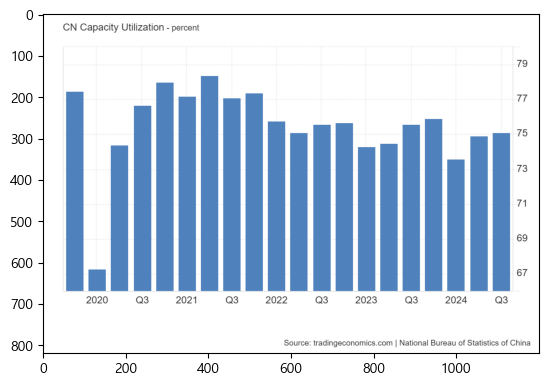

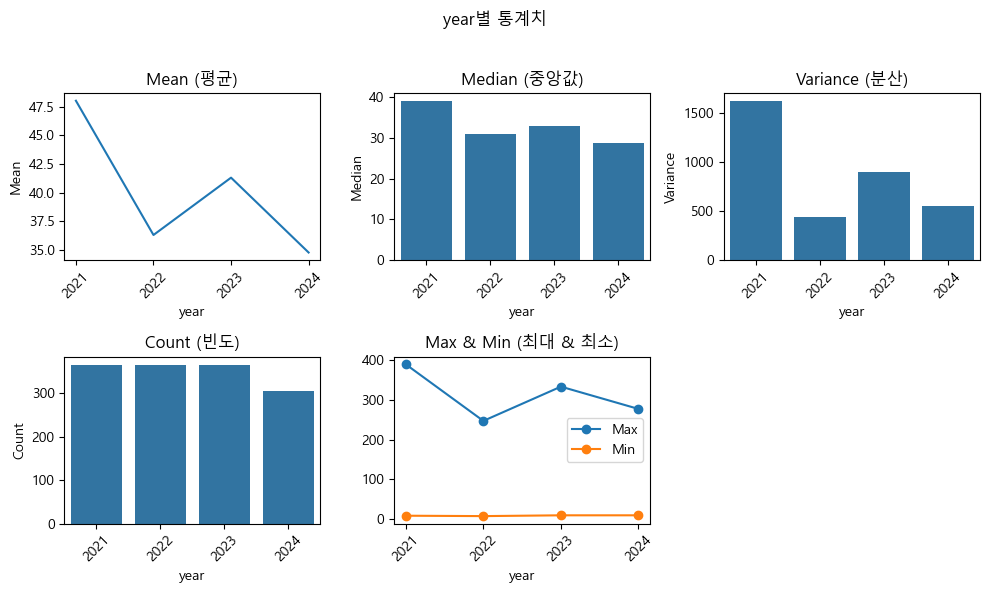

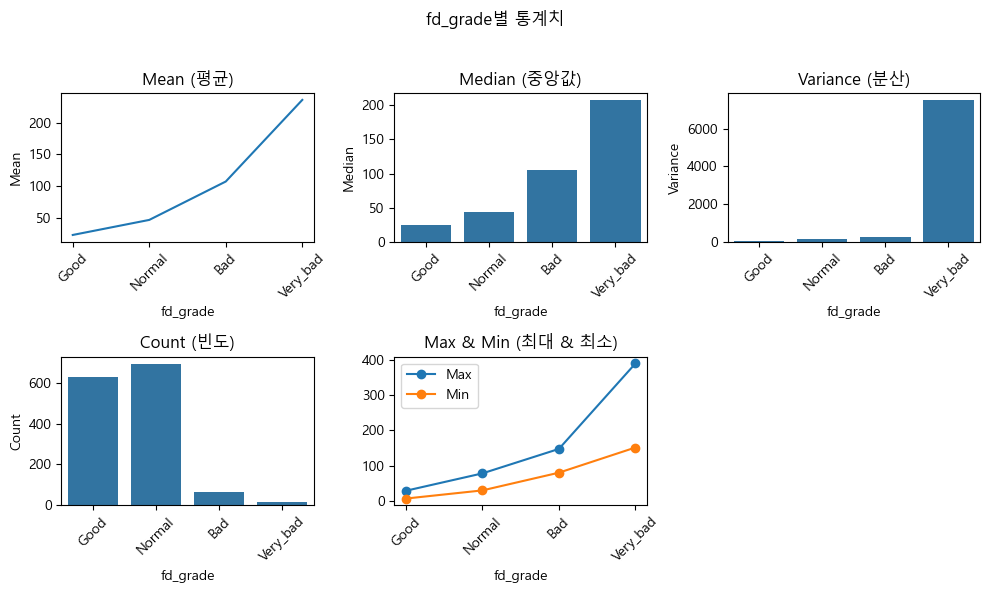

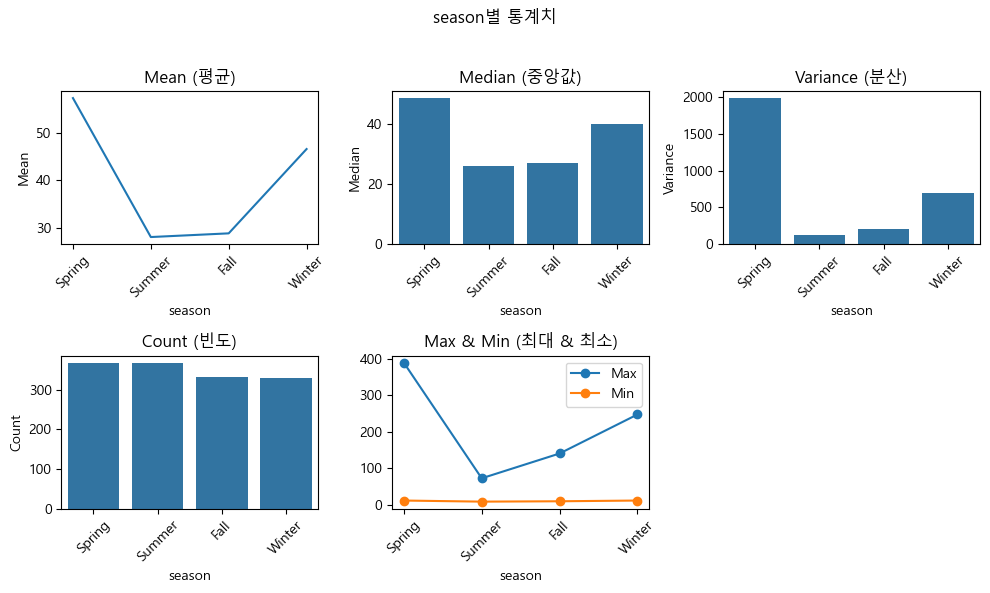

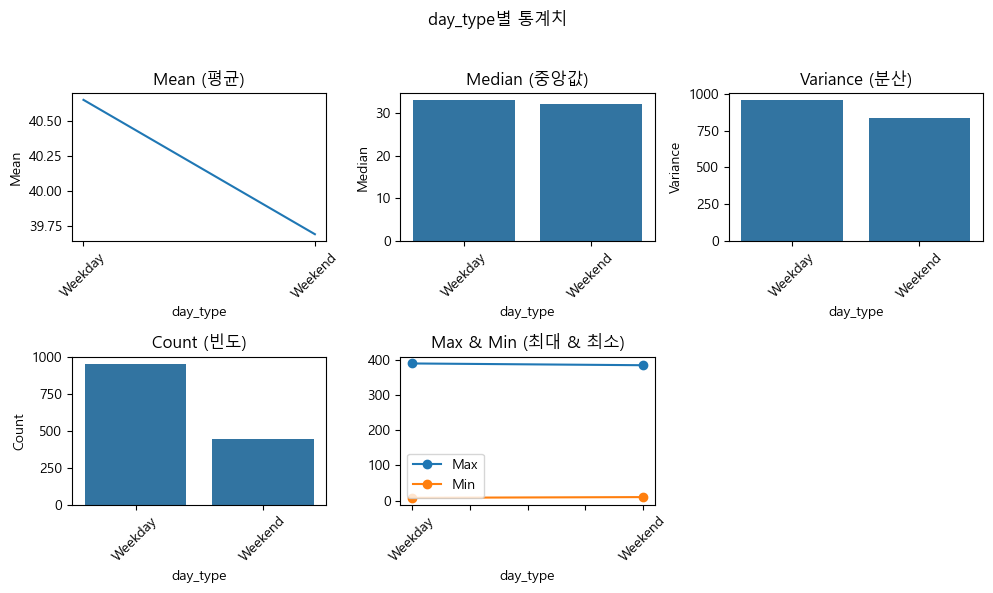

In [40]:
# 중국의 설비가동률 이미지
image = plt.imread('data/CN_Capacity_Utilization.png')
plt.imshow(image)

# 단일 그룹 시각화를 위해 지정한 함수에 적용
# 통계치 데이터프레임별로 그래프 그리기
for key, stats_df in combined_stats_fd1.items():
    plot_statistics(stats_df, key)

plt.show()

# 중국의 설비 가동률이 21년대비 22년 약 10%p감소
# 연간 평균 미세먼지 농도가 중국의 설비가동률 그래프와 비슷한 추세로 그려짐
# 양자 사이에 관계가 있을 것이라고 추측

2-1-5. 평균기온 - 분석

In [41]:
# 단일 그룹 분석을 위해 지정한 함수에 적용

# 평균기온
atdf_year_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "year", 
                    col_name = "avg_temp")
atdf_grade_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "at_grade", 
                    col_name = "avg_temp")
atdf_season_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "season", 
                    col_name = "avg_temp")
atdf_day_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "day_type", 
                    col_name = "avg_temp")

# 딕셔너리로 데이터프레입 합치기
combined_stats_at1 = {
    "year": atdf_year_stats,
    "at_grade": atdf_grade_stats,
    "season": atdf_season_stats,
    "day_type": atdf_day_stats
}

print( "단일 그룹 분석 - 평균기온")
# 결과 확인
for key, value in combined_stats_at1.items():
    print(f"\n\n{key} Stats: (평균기온)\n", value)

단일 그룹 분석 - 평균기온


year Stats: (평균기온)
        Max   Min       Mean  Median    Variance  Count
year                                                  
2021  31.7 -14.9  13.752055    14.1  110.257558    365
2022  30.9 -11.8  13.296164    14.8  120.122403    365
2023  30.9 -14.7  14.109041    15.8  111.775165    365
2024  31.8 -11.7  16.815461    18.4  103.621179    304


at_grade Stats: (평균기온)
             Max   Min       Mean  Median   Variance  Count
at_grade                                                  
Very_Cold -11.3 -14.9 -12.563636  -11.80   1.946545     11
Cold       -0.1  -9.8  -3.767763   -3.60   5.943921    152
Mild       14.9   0.0   7.799398    7.85  19.090764    498
Warm       29.9  15.0  22.719888   23.00  17.099716    714
Hot        31.8  30.0  30.795833   30.85   0.316069     24


season Stats: (평균기온)
          Max   Min       Mean  Median   Variance  Count
season                                                 
Spring  24.1  -4.1  13.883967   14.15  28.642004    368
S

2-1-6. 평균기온 - 시각화

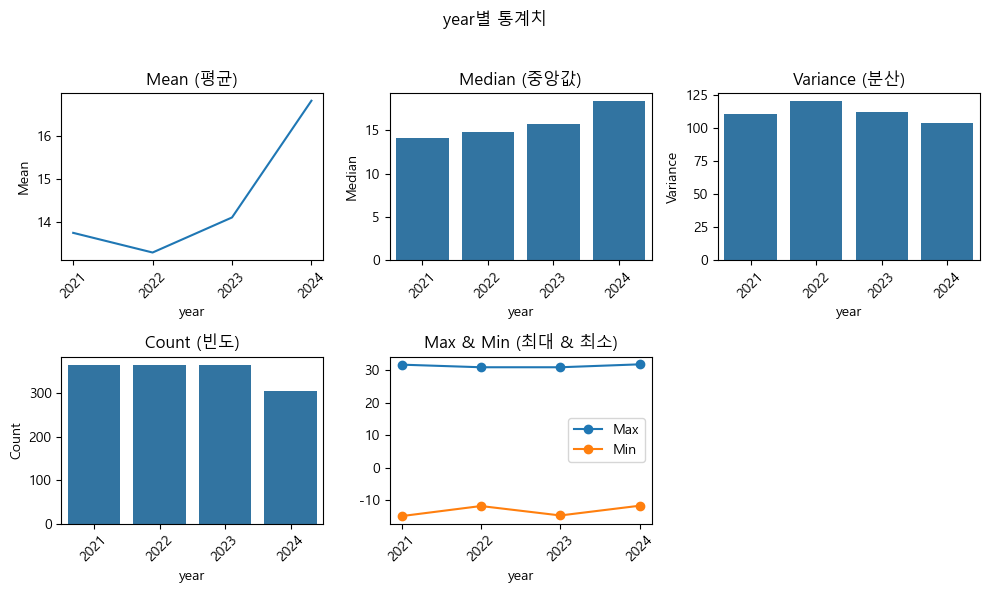

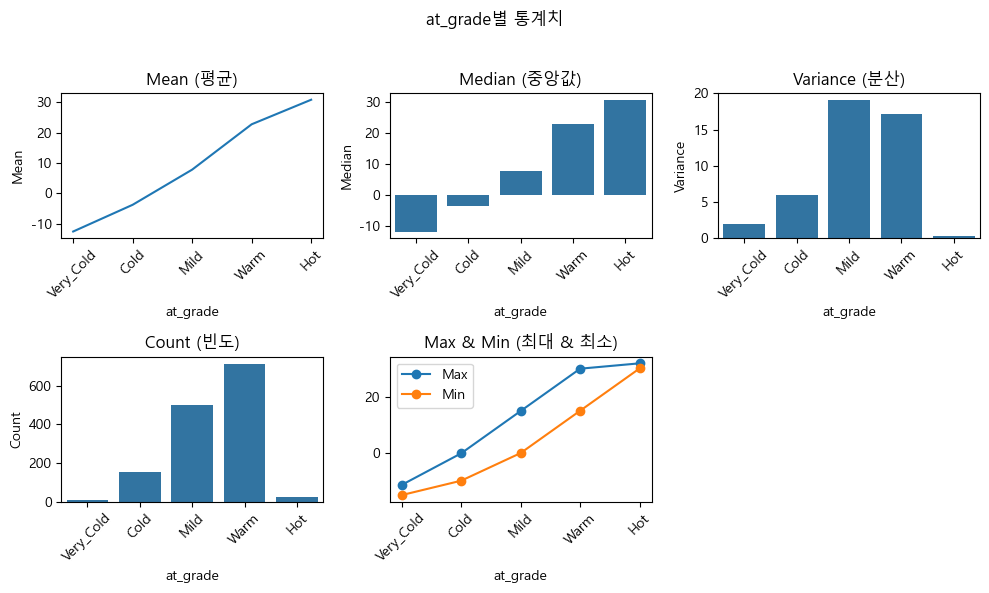

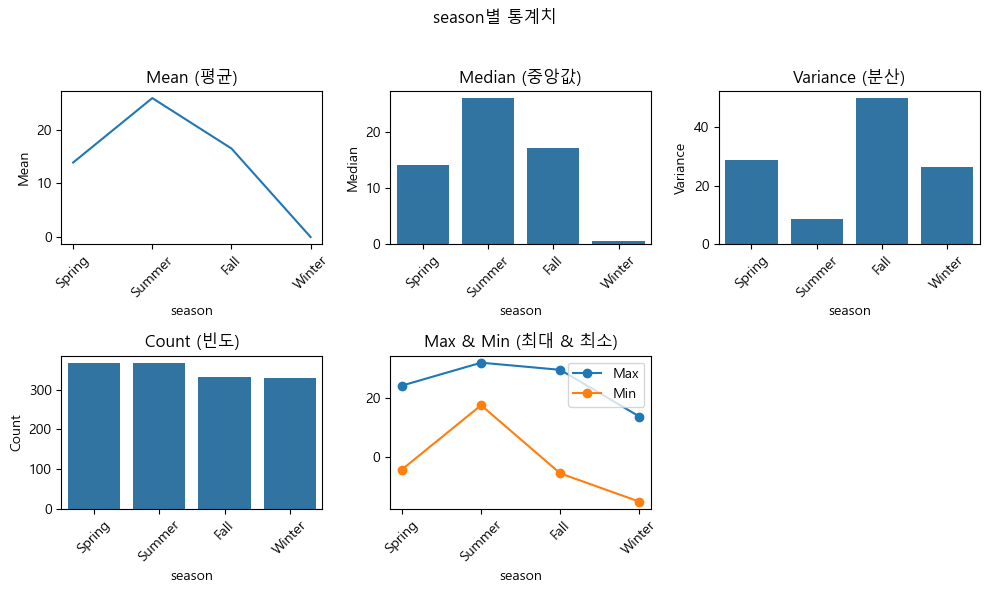

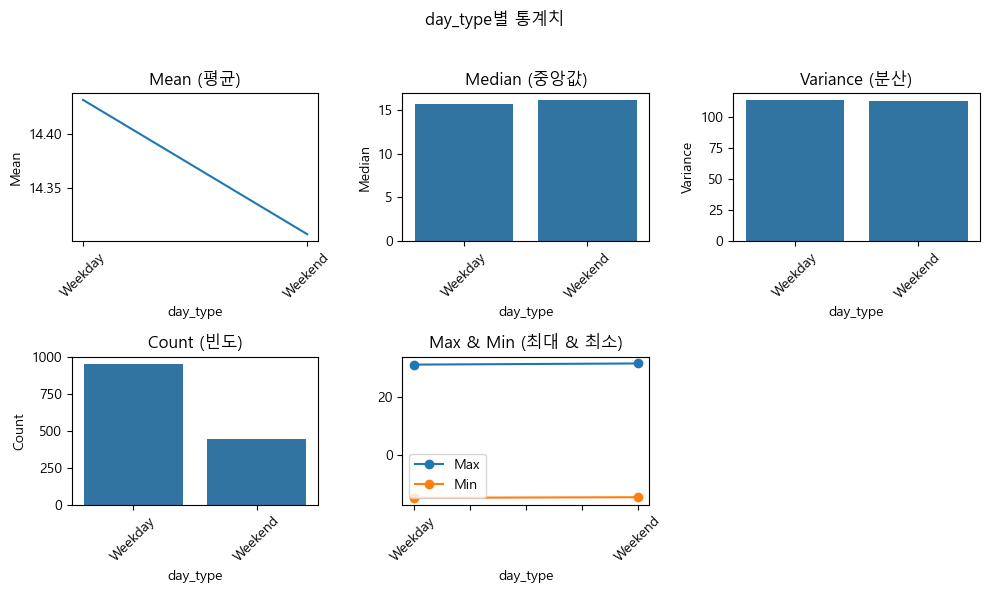

In [42]:
# 단일 그룹 시각화를 위해 지정한 함수에 적용

# 통계치 데이터프레임별로 그래프 그리기
for key, stats_df in combined_stats_at1.items():
    plot_statistics(stats_df, key)


2-1-7. 최저기온 - 분석

In [43]:
# 단일 그룹 분석을 위해 지정한 함수에 적용

# 최저기온
mitdf_year_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "year", 
                    col_name = "min_temp")
mitdf_grade_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "at_grade", 
                    col_name = "min_temp")
mitdf_season_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "season", 
                    col_name = "min_temp")
mitdf_day_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "day_type", 
                    col_name = "min_temp")

# 딕셔너리로 데이터프레입 합치기
combined_stats_mit1 = {
    "year": mitdf_year_stats,
    "at_grade": mitdf_grade_stats,
    "season": mitdf_season_stats,
    "day_type": mitdf_day_stats
}

print( "단일 그룹 분석 - 최저기온")
# 결과 확인
for key, value in combined_stats_mit1.items():
    print(f"\n\n{key} Stats: (최저기온)\n", value)

단일 그룹 분석 - 최저기온


year Stats: (최저기온)
        Max   Min       Mean  Median    Variance  Count
year                                                  
2021  27.8 -18.6   9.622466     9.7  118.285593    365
2022  27.4 -13.7   9.250959    10.4  127.108110    365
2023  27.3 -17.3  10.066027    11.1  119.389227    365
2024  28.2 -14.0  12.931250    13.9  108.162156    304


at_grade Stats: (최저기온)
             Max   Min       Mean  Median   Variance  Count
at_grade                                                  
Very_Cold -13.7 -18.6 -15.700000   -15.5   2.542000     11
Cold       -1.9 -13.5  -7.801974    -8.0   6.612248    152
Mild       13.4  -7.1   3.414859     3.4  19.628068    498
Warm       28.2   7.0  18.912325    19.1  23.751461    714
Hot        28.2  25.3  27.025000    27.2   0.460217     24


season Stats: (최저기온)
          Max   Min       Mean  Median   Variance  Count
season                                                 
Spring  20.8  -8.1   9.066033    9.65  29.244538    368
S

2-1-8. 최저기온 - 시각화

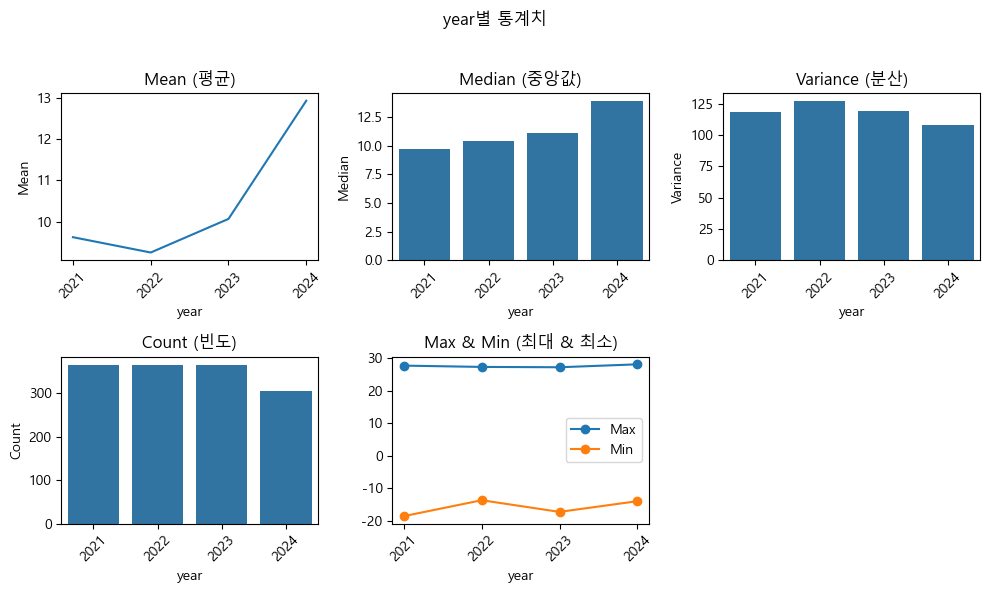

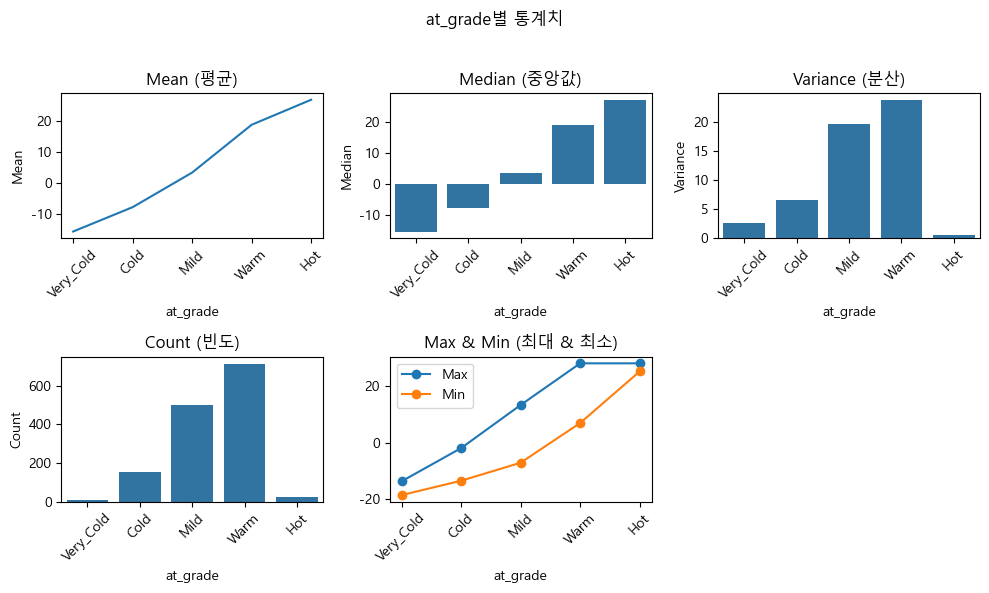

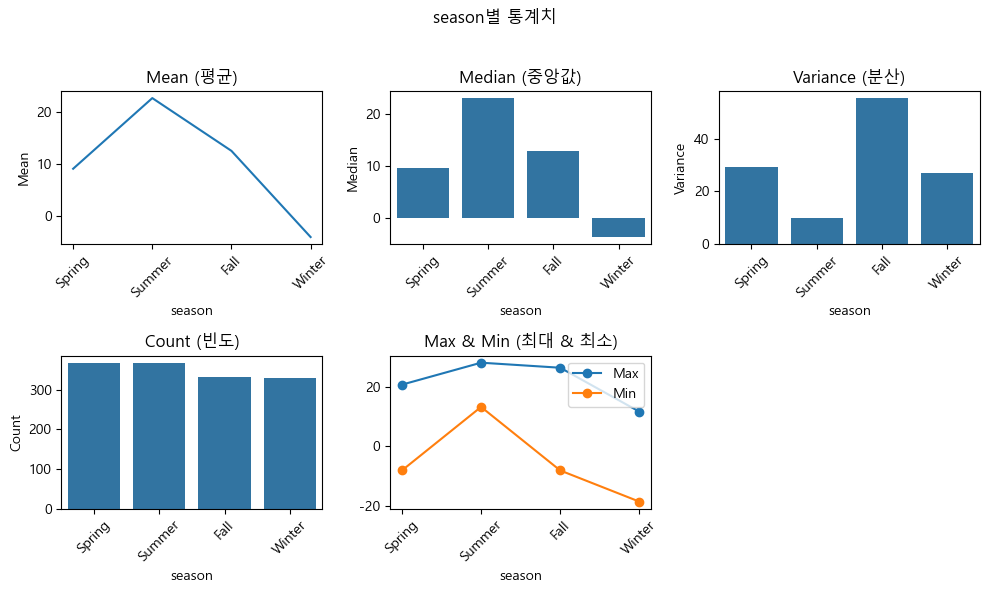

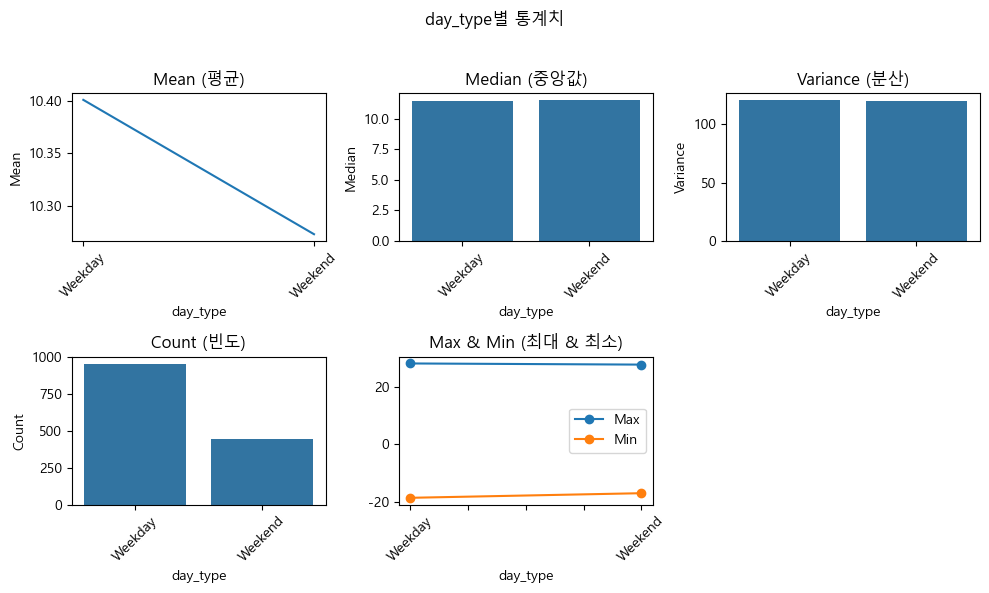

In [44]:
# 단일 그룹 시각화를 위해 지정한 함수에 적용

# 통계치 데이터프레임별로 그래프 그리기
for key, stats_df in combined_stats_mit1.items():
    plot_statistics(stats_df, key)


2-1-9. 최고기온 - 분석

In [45]:
# 단일 그룹 분석을 위해 지정한 함수에 적용

# 최고기온
matdf_year_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "year", 
                    col_name = "max_temp")
matdf_grade_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "at_grade", 
                    col_name = "max_temp")
matdf_season_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "season", 
                    col_name = "max_temp")
matdf_day_stats = group_analysis_by_single_column_fd_and_temp(
                    df = all_df, 
                    group_col_name = "day_type", 
                    col_name = "max_temp")

# 딕셔너리로 데이터프레입 합치기
combined_stats_mat1 = {
    "year": matdf_year_stats,
    "at_grade": matdf_grade_stats,
    "season": matdf_season_stats,
    "day_type": matdf_day_stats
}

print( "단일 그룹 분석 - 최고기온")
# 결과 확인
for key, value in combined_stats_mat1.items():
    print(f"\n\n{key} Stats: (최고기온)\n", value)

단일 그룹 분석 - 최고기온


year Stats: (최고기온)
        Max   Min       Mean  Median    Variance  Count
year                                                  
2021  36.5 -10.7  18.491781    19.2  109.582954    365
2022  36.1  -8.6  18.077808    20.2  117.245468    365
2023  35.8  -8.0  18.800000    21.2  109.182143    365
2024  36.4  -8.2  21.437500    24.2  105.349744    304


at_grade Stats: (최고기온)
             Max   Min       Mean  Median   Variance  Count
at_grade                                                  
Very_Cold  -5.4 -10.7  -7.845455   -8.00   1.678727     11
Cold        7.1  -6.4   0.823026    0.90   7.694367    152
Mild       23.4   1.6  12.844779   13.25  24.361753    498
Warm       35.8  16.6  27.237815   27.30  16.019438    714
Hot        36.5  33.6  35.150000   35.35   0.733043     24


season Stats: (최고기온)
          Max   Min       Mean  Median   Variance  Count
season                                                 
Spring  31.2   0.3  19.387500   19.45  34.152159    368
S

2-1-10. 최고기온 - 시각화

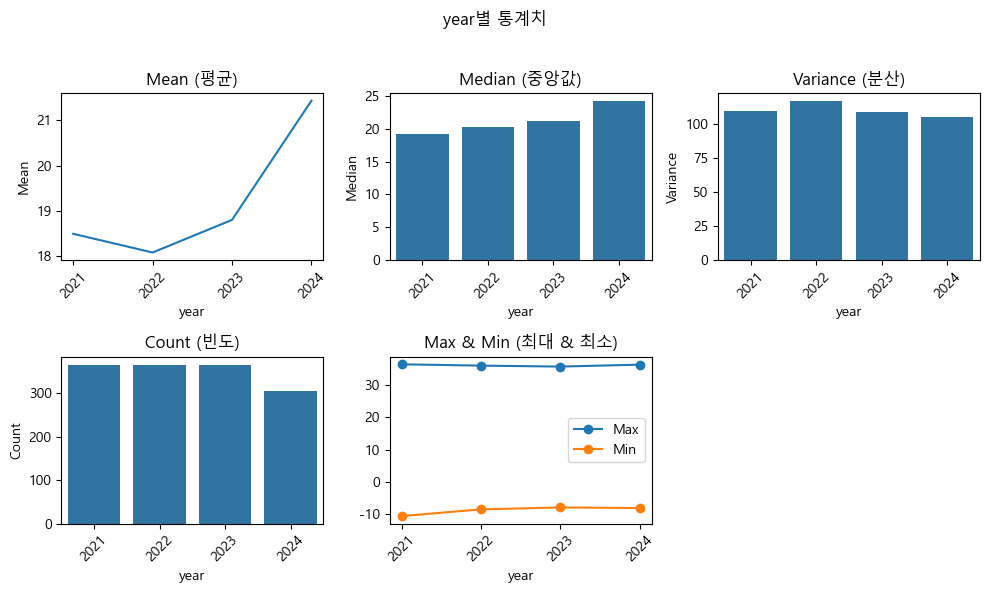

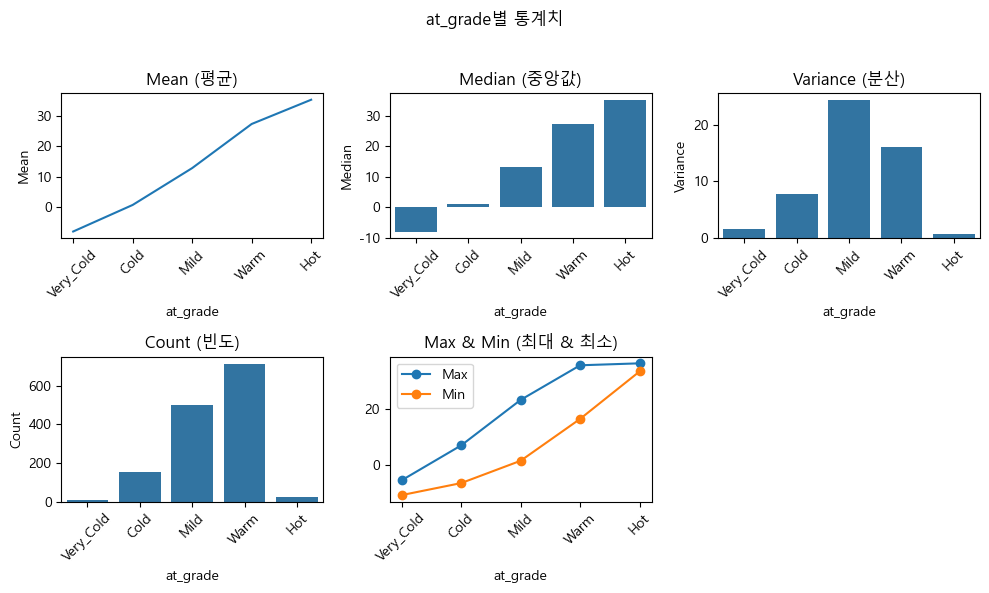

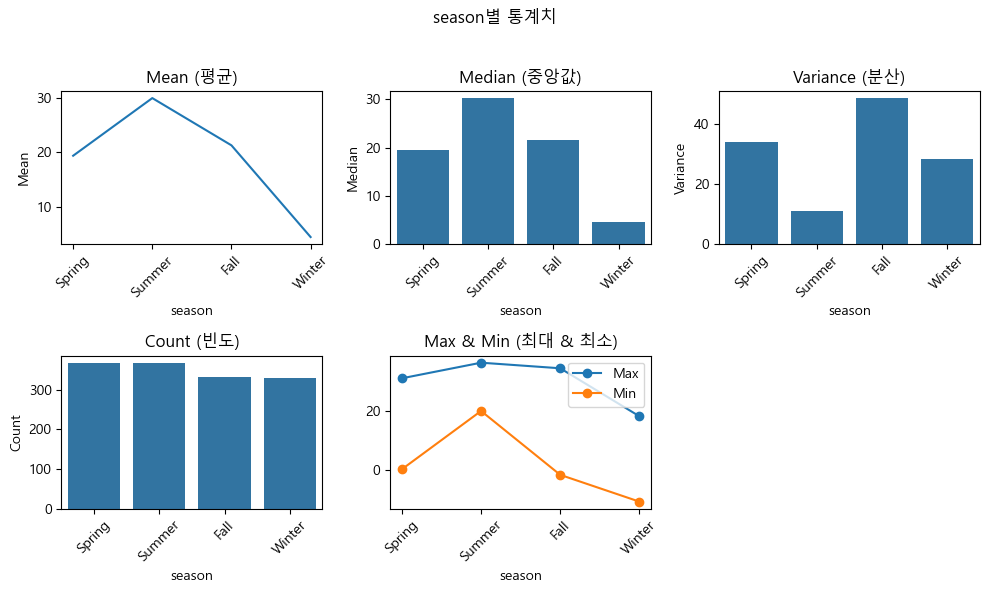

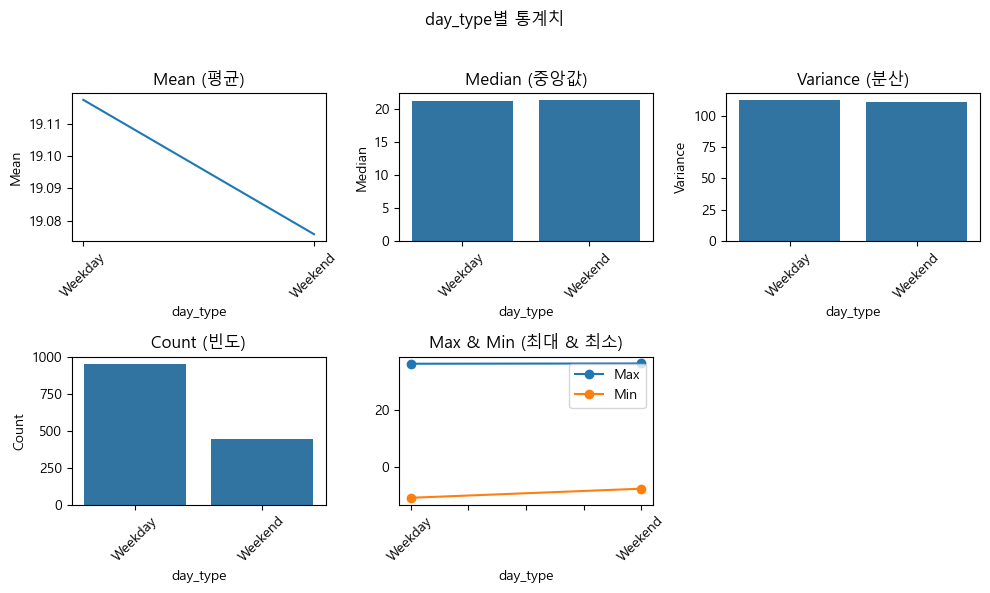

In [46]:
# 단일 그룹 시각화를 위해 지정한 함수에 적용

# 통계치 데이터프레임별로 그래프 그리기
for key, stats_df in combined_stats_mat1.items():
    plot_statistics(stats_df, key)


2-1-11. 강수량/적설량 - 분석을 위한 함수 정의

In [47]:
# 단일 그룹 분석을 위해 함수 지정
# 강수량과 적설량의 경우 0인 날이 많아, 
# 0인날과 아닌 날을 구분하여 개수를 세고, min만 0이 아닌 날의 값을 사용

def group_analysis_by_single_column(df, group_col_name, col_name):
    # 전체 count를 위한 그룹화 (0 포함)
    total_counts = df.groupby(group_col_name, observed=True)[col_name].agg([
        ("Total_Count", "count"),
        ("Zero_Count", lambda x: (x == 0).sum()), # 0인 값만 갯수 세기
        ("max", "max"),
        ("mean", "mean"),
        ("median_nz", "median"),
        ("var", "var")
    ])
    
    # 0이 아닌 값들에 대한 통계
    non_zero_stats = df[df[col_name] != 0].groupby(group_col_name, observed=True)[col_name].agg([
        ("cnt_nz", "count"),    # count non-zero
        ("min_nz", "min"),      # min non-zero
    ])
    
    # 두 결과를 병합
    combined_stats = pd.concat([total_counts, non_zero_stats], axis=1)
        
    return combined_stats

2-1-12. 강수량 - 분석

In [48]:
# 강수량
# 단일 그룹 분석 결과를 데이터 프레임으로 저장
df_year_stats = group_analysis_by_single_column(
                    df = all_df, 
                    group_col_name = "year", 
                    col_name = "precipitation(mm)")
df_pgrade_stats = group_analysis_by_single_column(
                    df = all_df, 
                    group_col_name = "p_grade", 
                    col_name = "precipitation(mm)")
df_season_stats = group_analysis_by_single_column(
                    df = all_df, 
                    group_col_name = "season", 
                    col_name = "precipitation(mm)")
df_day_stats = group_analysis_by_single_column(
                    df = all_df, 
                    group_col_name = "day_type", 
                    col_name = "precipitation(mm)")

# 딕셔너리로 데이터프레입 합치기
combined_stats_p1 = {
    "year": df_year_stats,
    "precipitation_grade": df_pgrade_stats,
    "season": df_season_stats,
    "day_type": df_day_stats
}

print( "단일 그룹 분석 - 강수량")
# 결과 확인
for key, value in combined_stats_p1.items():
    print(f"\n\n{key} Stats (강수량):\n", value)


단일 그룹 분석 - 강수량


year Stats (강수량):
       Total_Count  Zero_Count    max      mean  median_nz         var  cnt_nz  \
year                                                                            
2021          365         248   77.4  3.250685        0.0  113.906023     117   
2022          365         261  176.2  4.863836        0.0  347.998853     104   
2023          365         256   91.6  4.380274        0.0  169.876368     109   
2024          304         205  128.8  4.097697        0.0  178.651909      99   

      min_nz  
year          
2021     0.1  
2022     0.1  
2023     0.1  
2024     0.1  


precipitation_grade Stats (강수량):
           Total_Count  Zero_Count    max       mean  median_nz         var  \
p_grade                                                                      
Dry               970         970    0.0   0.000000       0.00    0.000000   
Light             294           0    9.9   2.582653       1.65    6.756865   
Moderate          104           0   48.

2-1-13. 강수량 - 시각화

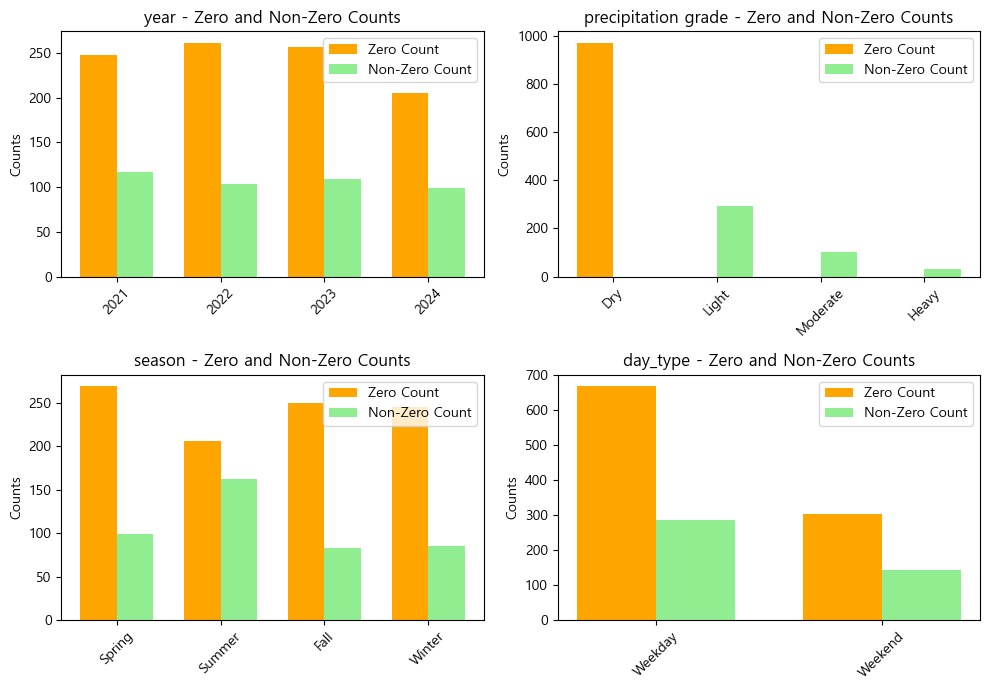

In [49]:
# 비 온 날과 안 온날의 개수 세기

# Set up a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()  # Flatten for easy indexing

# Define the keys and titles for each plot
keys = list(combined_stats_p1.keys())
titles = ["year", "precipitation grade", "season", "day_type"]

# Plot each dataset in a subplot
for i, key in enumerate(keys):
    value = combined_stats_p1[key]
    labels = value.index  # x-axis labels

    # Bar positions
    x = np.arange(len(labels))
    width = 0.35  # Width of the bars for 2 bars

    # Plot side-by-side bars for Zero_Count and Non-Zero Count (cnt_nz)
    axes[i].bar(x - width/2, value["Zero_Count"], width, label='Zero Count', color='orange')
    axes[i].bar(x + width/2, value["cnt_nz"], width, label='Non-Zero Count', color='lightgreen')

    # Labeling
    axes[i].set_title(f"{titles[i]} - Zero and Non-Zero Counts")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels, rotation=45)
    axes[i].set_ylabel("Counts")
    axes[i].legend(loc="upper right")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


2-1-14. 적설량 - 분석

In [50]:
# 적설량
# 단일 그룹 분석 결과를 데이터 프레임으로 저장
df_year_stats = group_analysis_by_single_column(
                    df = all_df, 
                    group_col_name = "year", 
                    col_name = "snow_depth(mm)")
df_Sgrade_stats = group_analysis_by_single_column(
                    df = all_df, 
                    group_col_name = "s_grade", 
                    col_name = "snow_depth(mm)")
df_season_stats = group_analysis_by_single_column(
                    df = all_df, 
                    group_col_name = "season", 
                    col_name = "snow_depth(mm)")
df_day_stats = group_analysis_by_single_column(
                    df = all_df, 
                    group_col_name = "day_type", 
                    col_name = "snow_depth(mm)")

# 딕셔너리로 데이터프레입 합치기
combined_stats_s1 = {
    "year": df_year_stats,
    "snow_depth_grade": df_Sgrade_stats,
    "season": df_season_stats,
    "Day Type": df_day_stats
}

print( "단일 그룹 분석 - 적설량")
# 결과 확인
for key, value in combined_stats_s1.items():
    print(f"\n\n{key} Stats (적설량):\n", value)


단일 그룹 분석 - 적설량


year Stats (적설량):
       Total_Count  Zero_Count    max      mean  median_nz         var  cnt_nz  \
year                                                                            
2021          365         340   51.0  1.490411        0.0   49.662683      25   
2022          365         334   50.0  1.298630        0.0   32.457278      31   
2023          365         349  122.0  1.230137        0.0   79.172166      16   
2024          304         286  138.0  2.289474        0.0  148.199757      18   

      min_nz  
year          
2021     1.0  
2022     1.0  
2023     2.0  
2024     2.0  


snow_depth_grade Stats (적설량):
                Total_Count  Zero_Count    max        mean  median_nz  \
s_grade                                                                
No_Snow               1309        1309    0.0    0.000000        0.0   
Light_Snow              54           0   20.0    9.500000        9.0   
Moderate_Snow           33           0   88.0   39.030303       36

2-1-15. 적설량 - 시각화

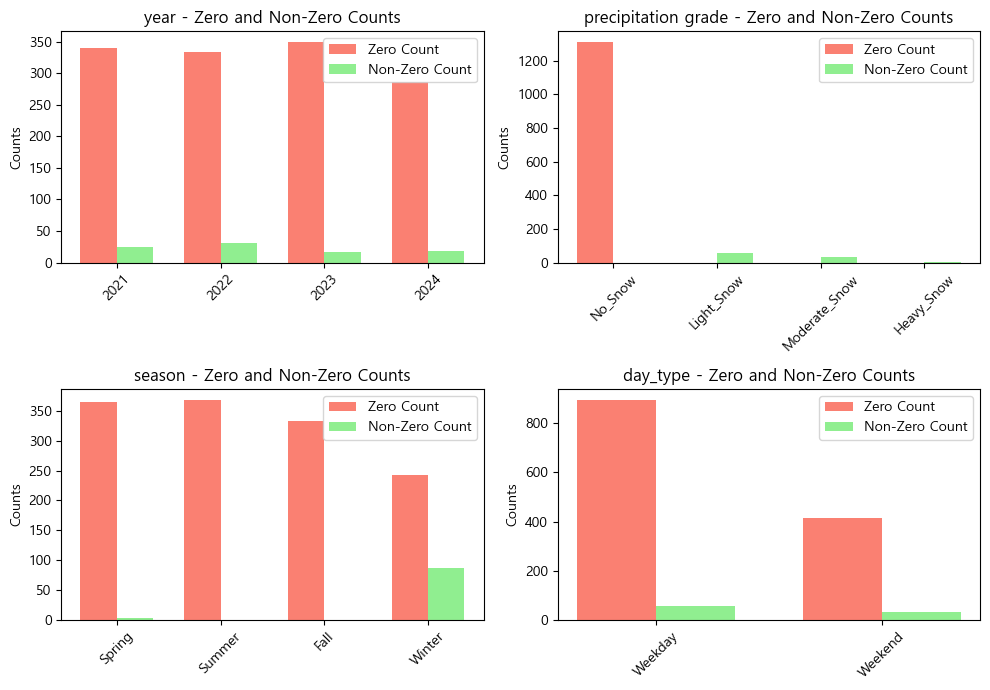

In [51]:
# 눈 온 날과 안 온날의 개수 세기

# Set up a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()  # Flatten for easy indexing

# Define the keys and titles for each plot
keys = list(combined_stats_s1.keys())
titles = ["year", "precipitation grade", "season", "day_type"]

# Plot each dataset in a subplot
for i, key in enumerate(keys):
    value = combined_stats_s1[key]
    labels = value.index  # x-axis labels

    # Bar positions
    x = np.arange(len(labels))
    width = 0.35  # Width of the bars for 2 bars

    # Plot side-by-side bars for Zero_Count and Non-Zero Count (cnt_nz)
    axes[i].bar(x - width/2, value["Zero_Count"], width, label='Zero Count', color='salmon')
    axes[i].bar(x + width/2, value["cnt_nz"], width, label='Non-Zero Count', color='lightgreen')

    # Labeling
    axes[i].set_title(f"{titles[i]} - Zero and Non-Zero Counts")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels, rotation=45)
    axes[i].set_ylabel("Counts")
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
# 시각적으로 보듯이 눈이 온 날이 매우 희박하여 유의미한 인사이트를 얻기 어려울 것으로 예상됨

### 2-2. 두개 그룹 분석 - 연도별/계절별, 연도별/등급별, 계절별/등급별

2-2-1. 미세먼지와 기온 분석을 위한 함수 정의

In [52]:
def group_analysis_by_two_columns_fd_and_temp(df, group_col1, group_col2, target_col):
    # 두 컬럼으로 그룹화
    grouped_df = df.groupby([group_col1, group_col2], observed=True)
    
    # 통계 계산 및 컬럼 이름 지정 (열 이름, 계산 방법)
    stats = grouped_df[target_col].agg([
    ("Max", "max"),
    ("Min", "min"),
    ("Mean", "mean"),
    ("Variance", "var"),
    ("Count", "count"),
    ("Median", "median"),                   # 중앙값
    ("Q1", lambda x: x.quantile(0.25)),     # 1사분위수 (Q1)
    ("Q3", lambda x: x.quantile(0.75)),     # 3사분위수 (Q3)
    ("IQR", lambda x: x.quantile(0.75) - x.quantile(0.25)),     # IQR
    ("Range", lambda x: x.max() - x.min())  # 범위
])
    return stats


2-2-2. 미세먼지와 기온 시각화를 위한 함수 정의

In [53]:
def create_double_group_plots(stats_dict, metric="Mean", figsize=(15, 10)):
    """
    Create visualization for double-grouped statistics
    
    Parameters:
    stats_dict: Dictionary containing the grouped statistics
    metric: The statistical measure to plot (e.g., "Mean", "Max", "Min")
    figsize: Size of the figure
    """
    
    def plot_heatmap(data, title, ax):
        # Reset index to get grouping columns as regular columns
        plot_data = data[metric].unstack()
        
        # Create heatmap
        sns.heatmap(plot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax)
        ax.set_title(title)
        plt.setp(ax.get_xticklabels(), rotation=45)
        plt.setp(ax.get_yticklabels(), rotation=0)

    def plot_line(data, title, ax):
        # Reset index to get grouping columns as regular columns
        plot_data = data[metric].unstack()
        
        # Plot lines
        plot_data.plot(marker='o', ax=ax)
        ax.set_title(title)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True)

    def plot_bar(data, title, ax):
        # Reset index to get grouping columns as regular columns
        plot_data = data[metric].unstack()
        
        # Plot bars
        plot_data.plot(kind='bar', ax=ax)
        ax.set_title(title)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.setp(ax.get_xticklabels(), rotation=45)
        ax.grid(True)

    # Create subplots for each group combination
    n_plots = len(stats_dict)
    n_rows = (n_plots + 1) // 2  # Round up division
    
    fig = plt.figure(figsize=figsize)
    fig.suptitle(f'{metric} Values by Different Groupings', fontsize=16, y=0.95)
    
    for i, (key, stats) in enumerate(stats_dict.items(), 1):
        ax = plt.subplot(n_rows, 2, i)
        
        # Choose plot type based on the data structure
        if 'year' in key:
            plot_line(stats, key, ax)
        elif 'season' in key:
            plot_bar(stats, key, ax)
        else:
            plot_heatmap(stats, key, ax)
            
    plt.tight_layout()
    plt.show()

2-2-3. 미세먼지 - 분석

In [54]:
# 미세먼지 함수실행

df_year_fd_grade_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "fd_grade", 
    target_col = "fine_dust(㎍/㎥)")
df_year_season_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "fine_dust(㎍/㎥)")
df_year_day_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "fine_dust(㎍/㎥)")
df_fd_grade_season_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "fd_grade", 
    group_col2 = "season", 
    target_col = "fine_dust(㎍/㎥)")
df_fd_grade_day_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "fd_grade", 
    group_col2 = "day_type", 
    target_col = "fine_dust(㎍/㎥)")
df_season_day_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "fine_dust(㎍/㎥)")

# 결과를 딕셔너리로 정리
double_group_stats_fd2 = {
    "year-fd_grade": df_year_fd_grade_stats,
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "fd_grade-season": df_fd_grade_season_stats,
    "fd_grade-Day": df_fd_grade_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 미세먼지")
for key, value in double_group_stats_fd2.items():
    print(f"\n{key} Stats: (미세먼지)\n", value)

2. 이중 그룹 분석 - 미세먼지

year-fd_grade Stats: (미세먼지)
                  Max    Min        Mean      Variance  Count      Median  \
year fd_grade                                                              
2021 Good       30.0    9.0   21.665559     27.347702    130   22.000000   
     Normal     78.0   31.0   48.628856    158.954940    195   46.641509   
     Bad       146.0   81.0  107.558824    291.041889     34  107.500000   
     Very_bad  389.0  156.0  262.500000  11896.300000      6  243.500000   
2022 Good       30.0    8.0   23.416613     27.809533    176   25.000000   
     Normal     79.0   31.0   44.711703    130.878643    181   41.000000   
     Bad       129.0   88.0  104.333333    205.466667      6  100.500000   
     Very_bad  247.0  169.0  208.000000   3042.000000      2  208.000000   
2023 Good       30.0   10.0   22.256133     30.813703    151   23.000000   
     Normal     78.0   31.0   46.458544    169.915082    192   43.500000   
     Bad       148.0   88.0  106.666667

2-2-4. 미세먼지 - 시각화

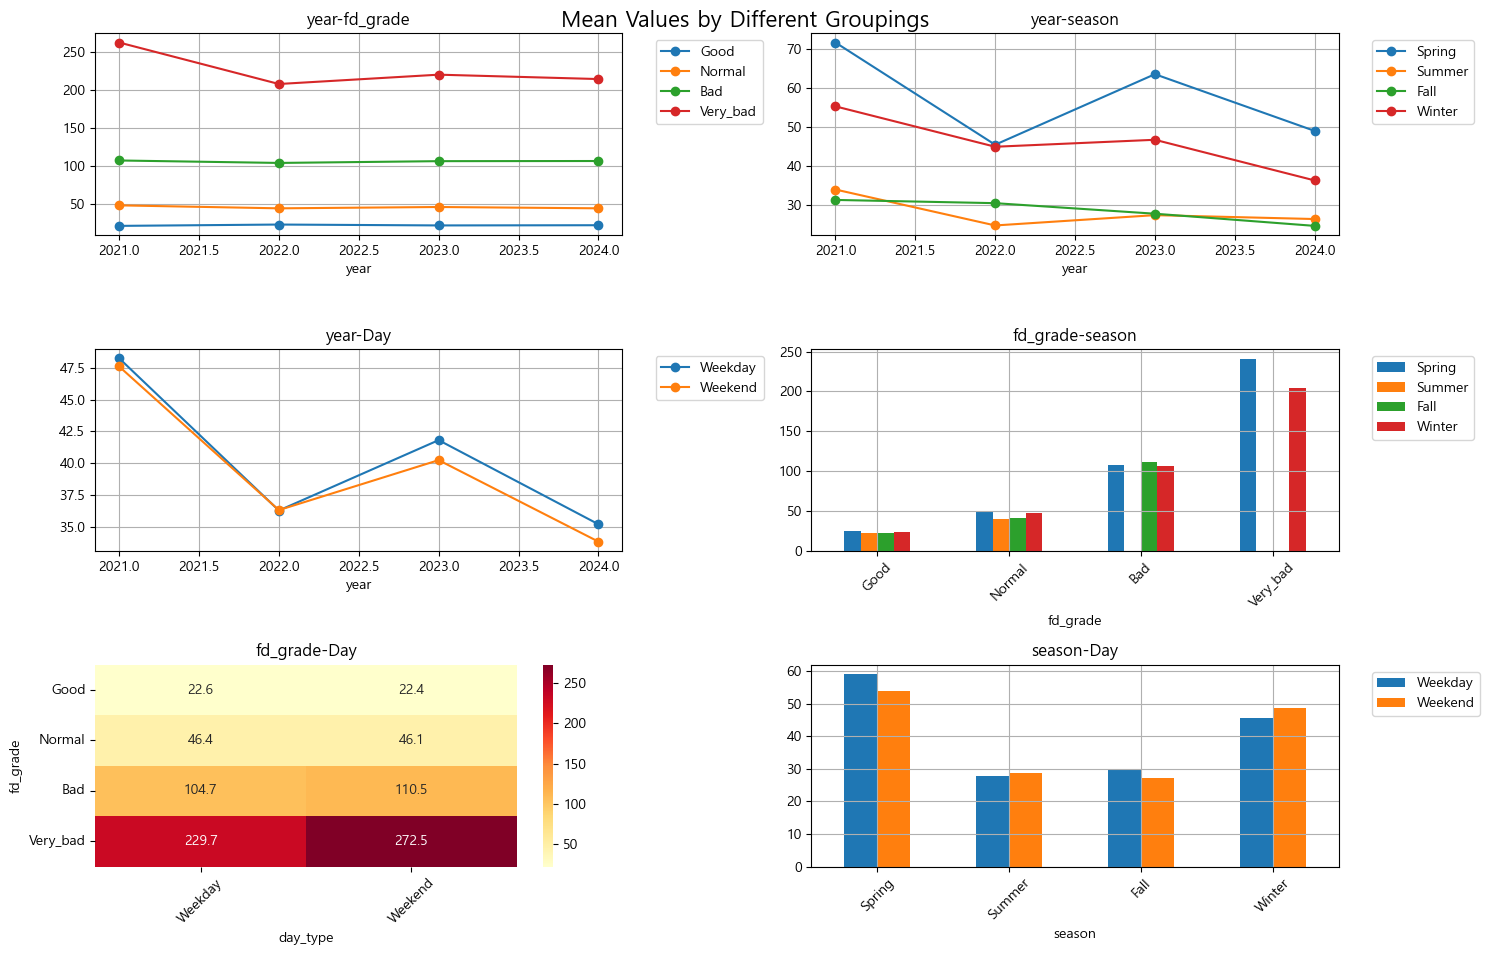

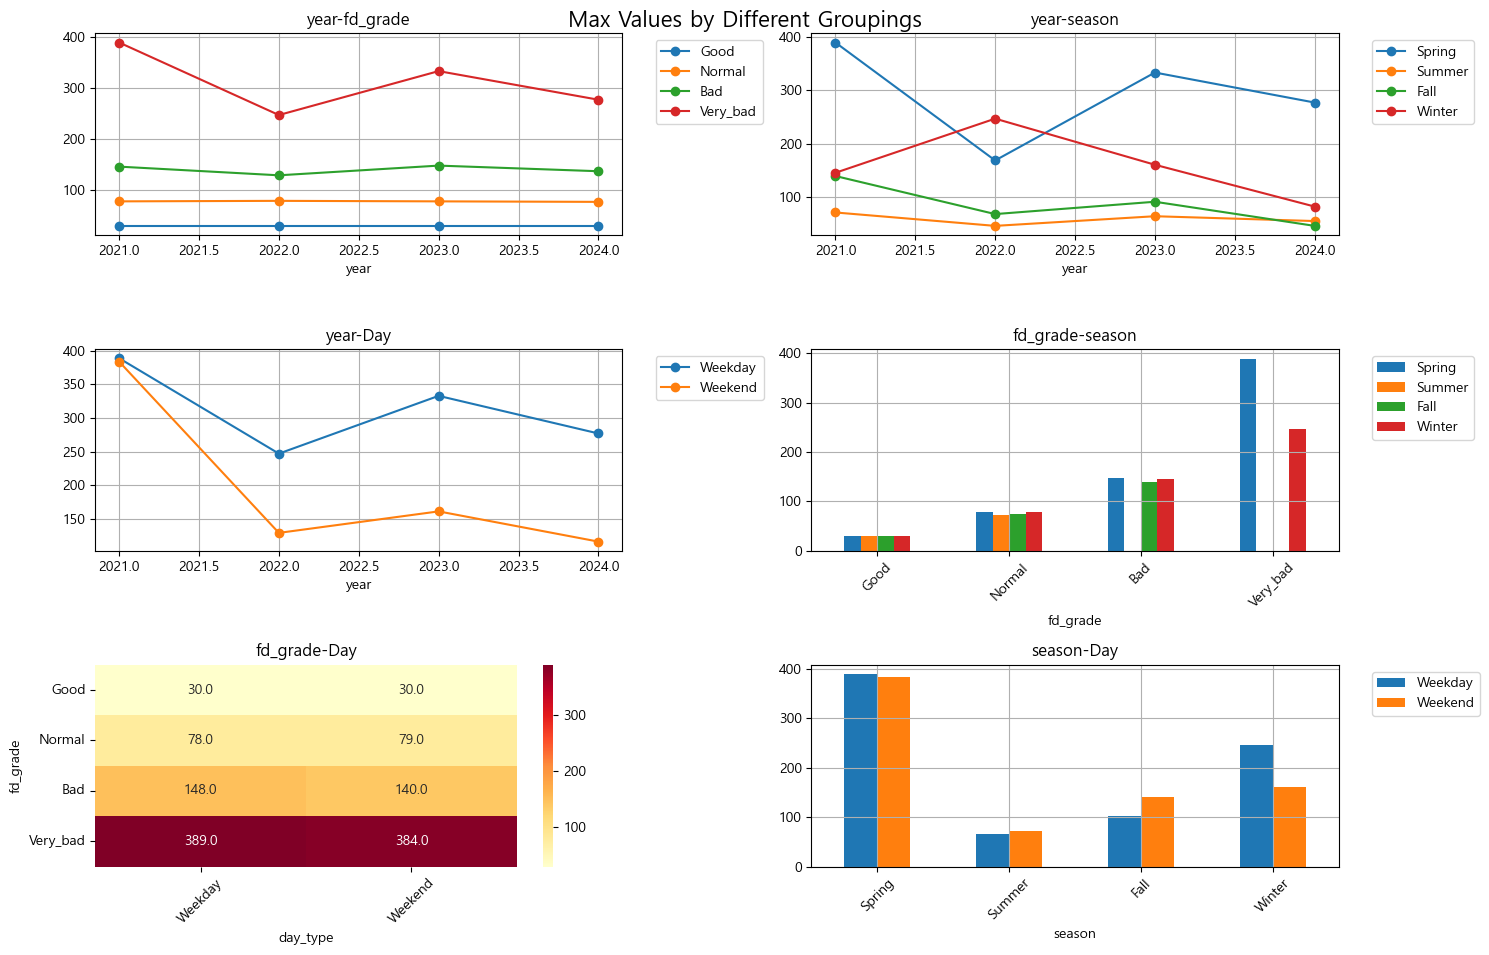

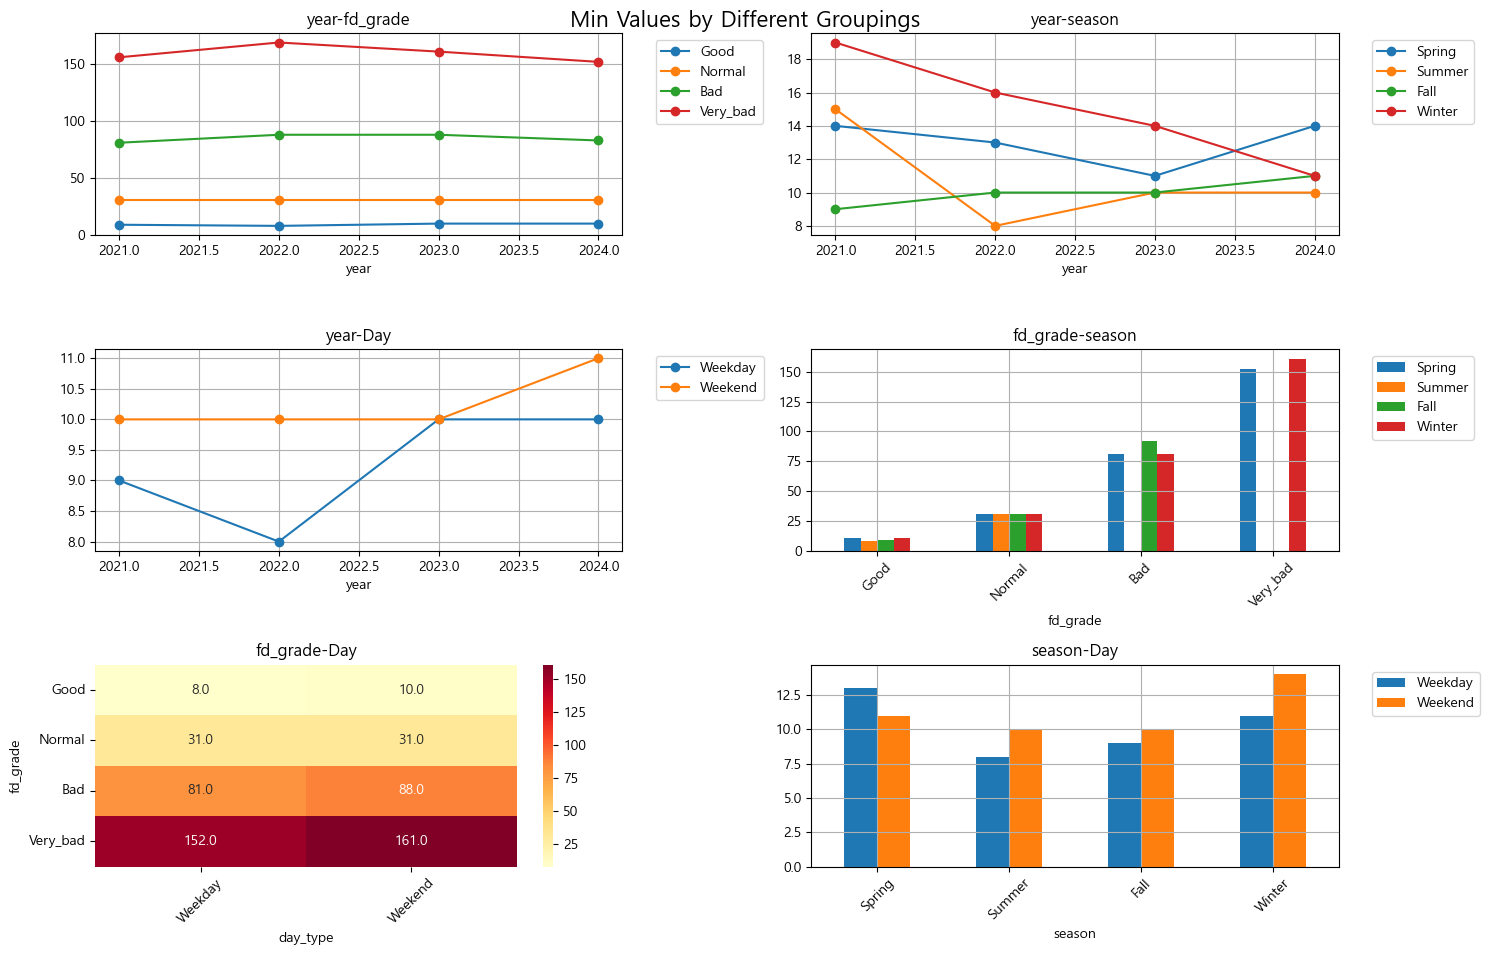

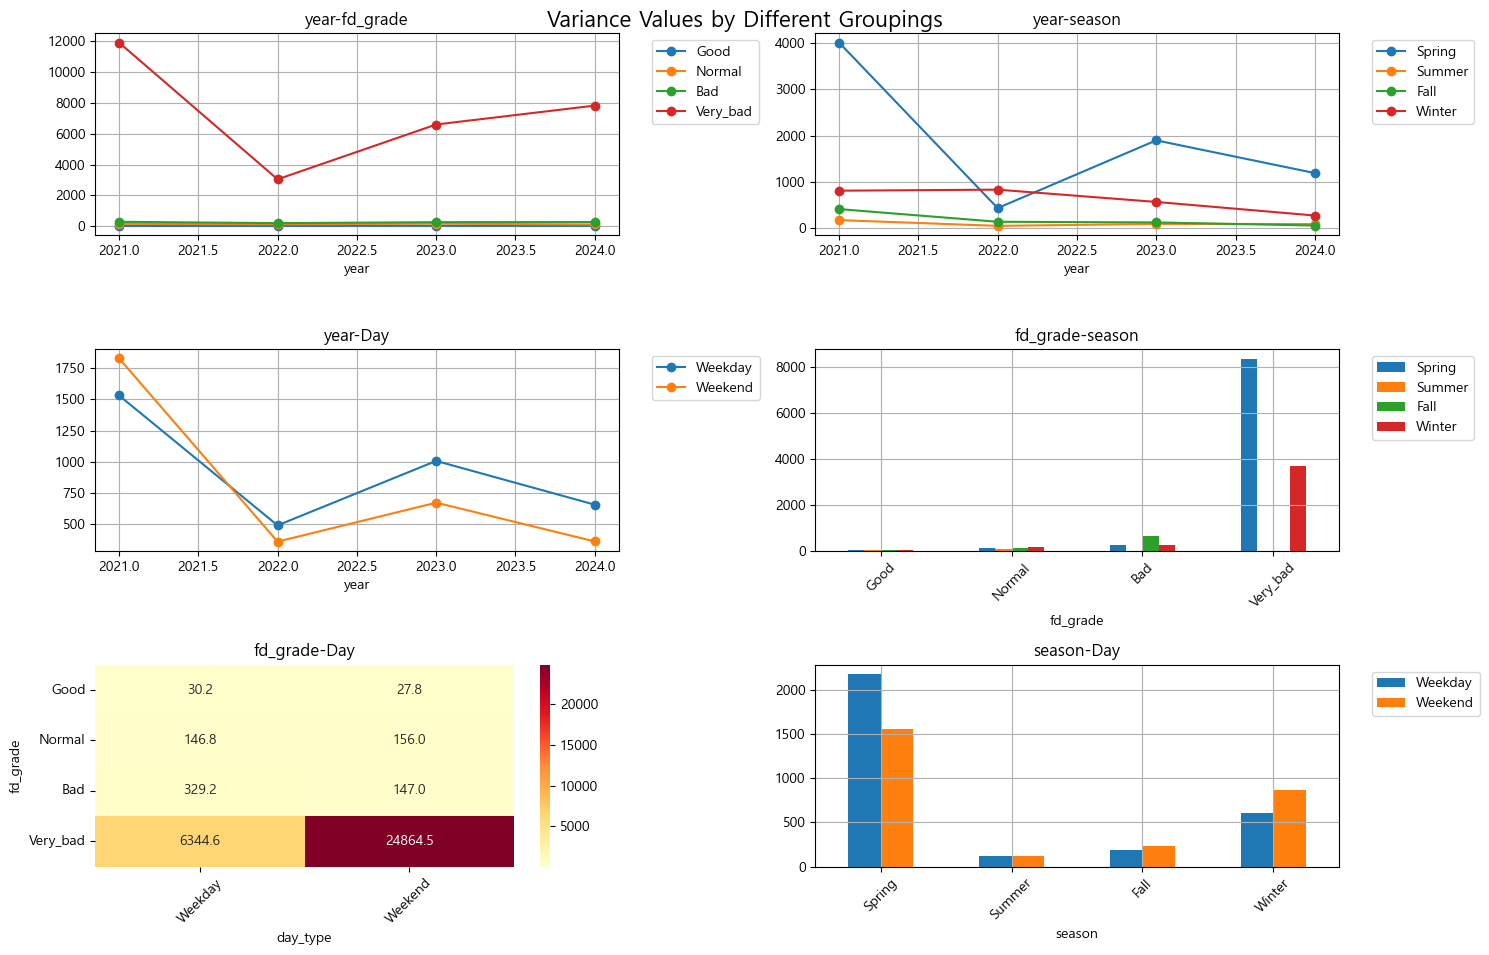

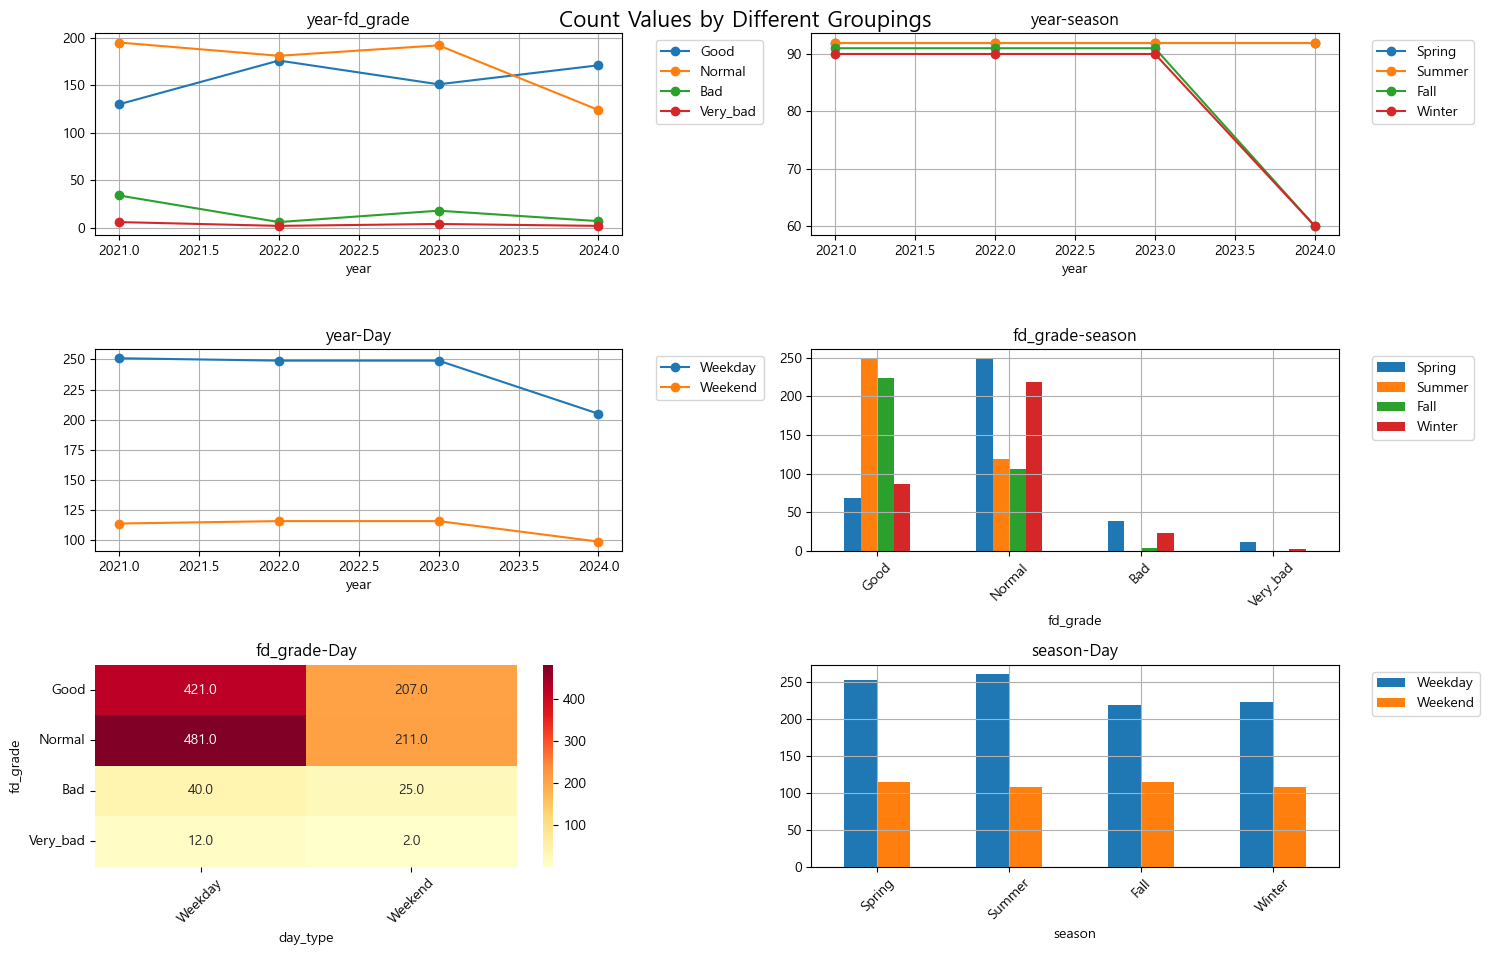

In [55]:
# 각 통계치별로 그래프 생성
metrics = ["Mean", "Max", "Min", "Variance", "Count"]
for metric in metrics:
    create_double_group_plots(double_group_stats_fd2, metric=metric)

2-2-5. 평균기온 - 분석

In [56]:
# 평균기온 함수실행

df_year_at_grade_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "at_grade", 
    target_col = "avg_temp")
df_year_season_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "avg_temp")
df_year_day_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "avg_temp")
df_at_grade_season_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "at_grade", 
    group_col2 = "season", 
    target_col = "avg_temp")
df_at_grade_day_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "at_grade", 
    group_col2 = "day_type", 
    target_col = "avg_temp")
df_season_day_stats = group_analysis_by_two_columns_fd_and_temp(
    df = all_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "avg_temp")

# 결과를 딕셔너리로 정리
double_group_stats_at2 = {
    "year-at_grade": df_year_at_grade_stats,
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "at_grade-season": df_at_grade_season_stats,
    "at_grade-Day": df_at_grade_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 평균기온")
for key, value in double_group_stats_at2.items():
    print(f"\n{key} Stats: (평균기온)\n", value)

2. 이중 그룹 분석 - 평균기온

year-at_grade Stats: (평균기온)
                  Max   Min       Mean   Variance  Count  Median      Q1  \
year at_grade                                                             
2021 Very_Cold -11.7 -14.9 -13.080000   2.242000      5  -12.20 -14.500   
     Cold       -0.1  -8.8  -4.375000   5.611643     36   -4.55  -5.725   
     Mild       14.9   0.0   8.394079  15.746786    152    8.80   5.300   
     Warm       29.8  15.0  22.620859  13.874007    163   22.90  19.900   
     Hot        31.7  30.4  31.033333   0.215000      9   31.20  30.500   
2022 Very_Cold -11.8 -11.8 -11.800000        NaN      1  -11.80 -11.800   
     Cold       -0.1  -9.5  -4.003175   5.165796     63   -3.50  -5.500   
     Mild       14.9   0.0   8.542623  18.478829    122    9.60   4.925   
     Warm       29.7  15.0  22.674011  15.619775    177   22.80  19.700   
     Hot        30.9  30.7  30.800000   0.020000      2   30.80  30.750   
2023 Very_Cold -11.3 -14.7 -12.325000   2.535833   

2-2-6. 평균기온 - 시각화

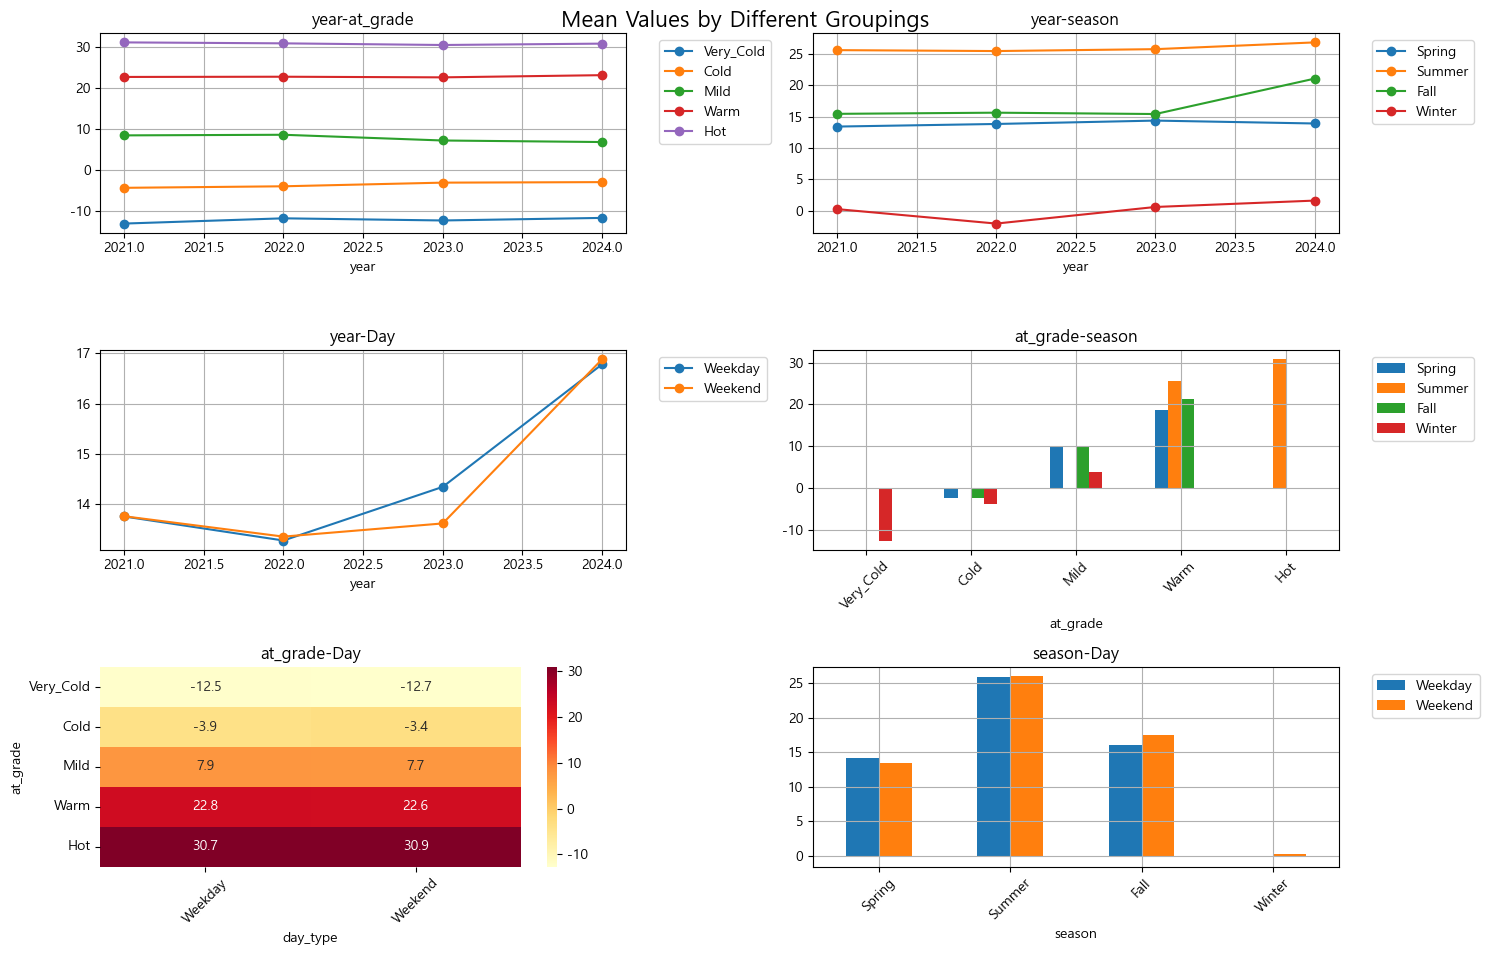

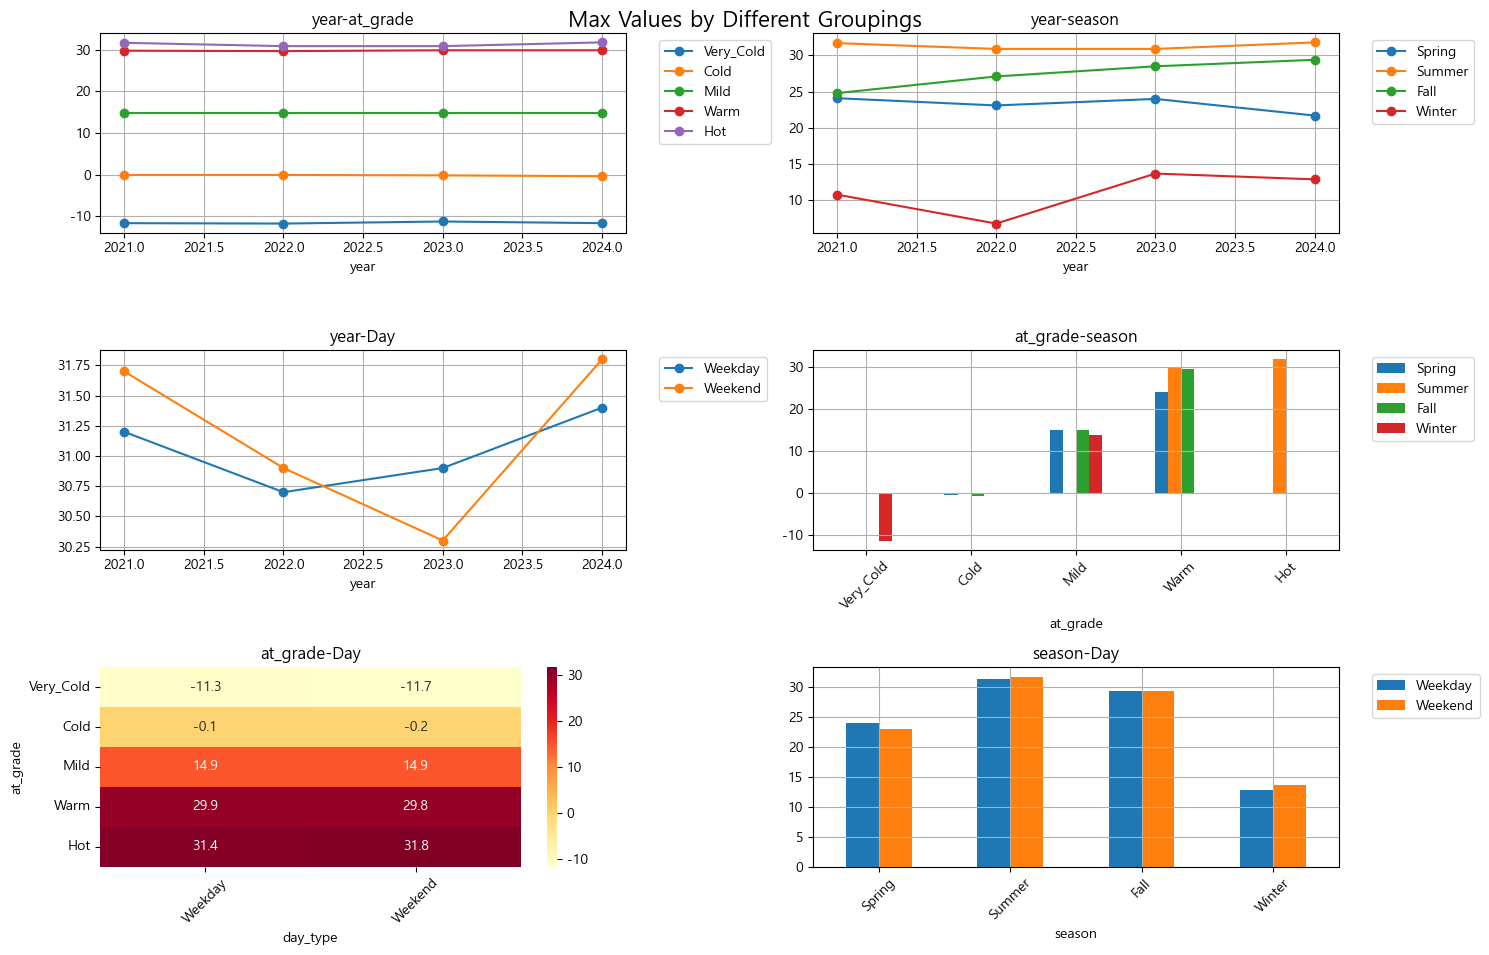

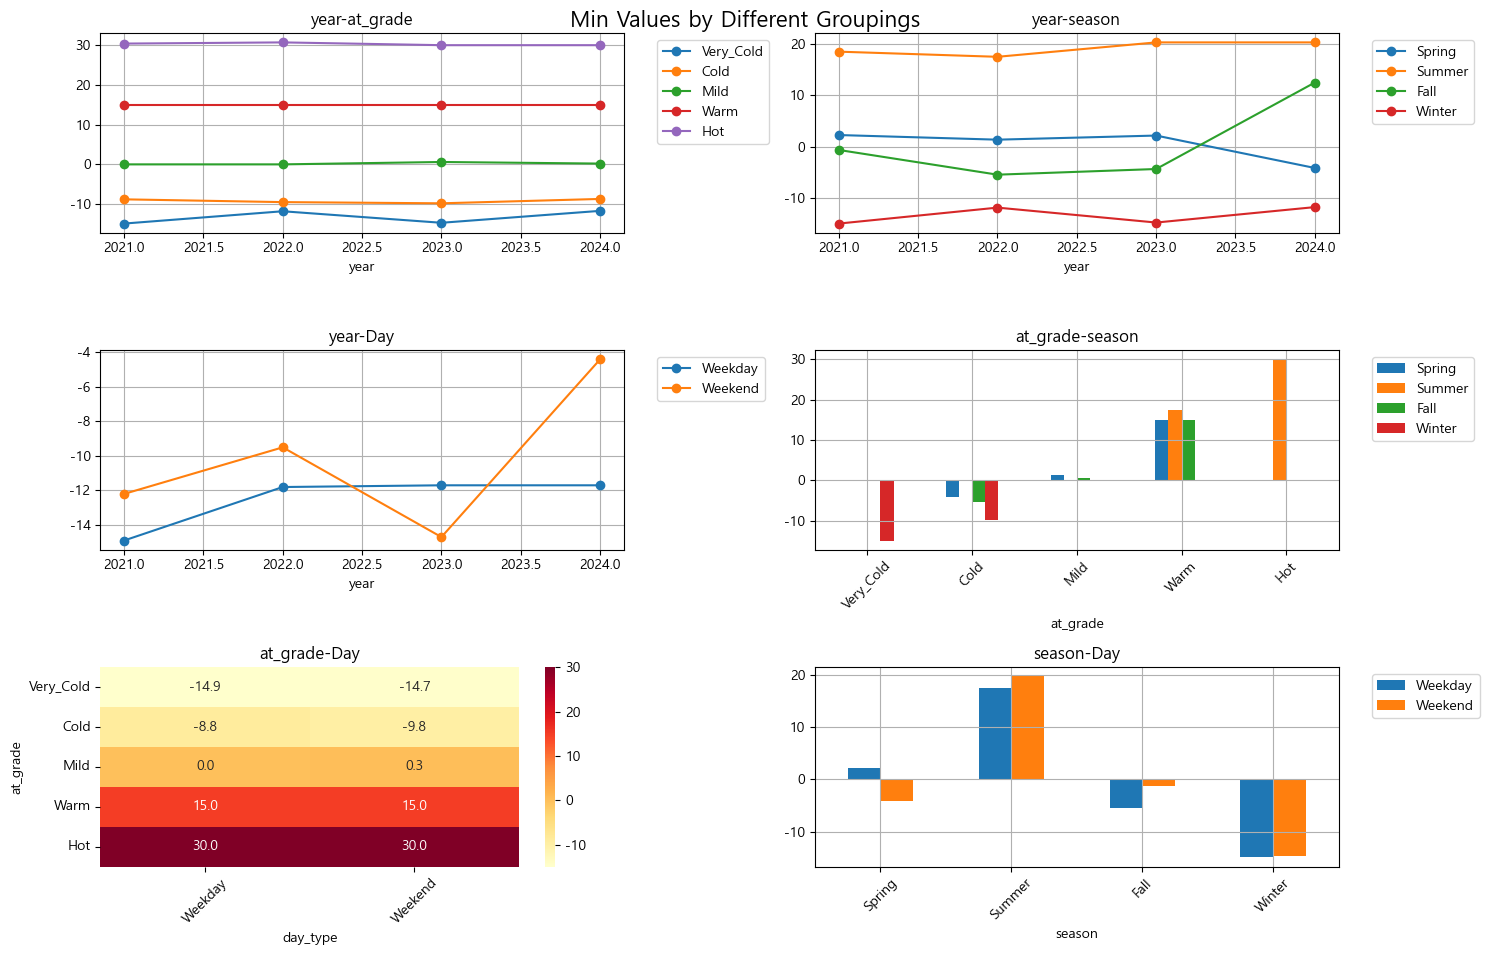

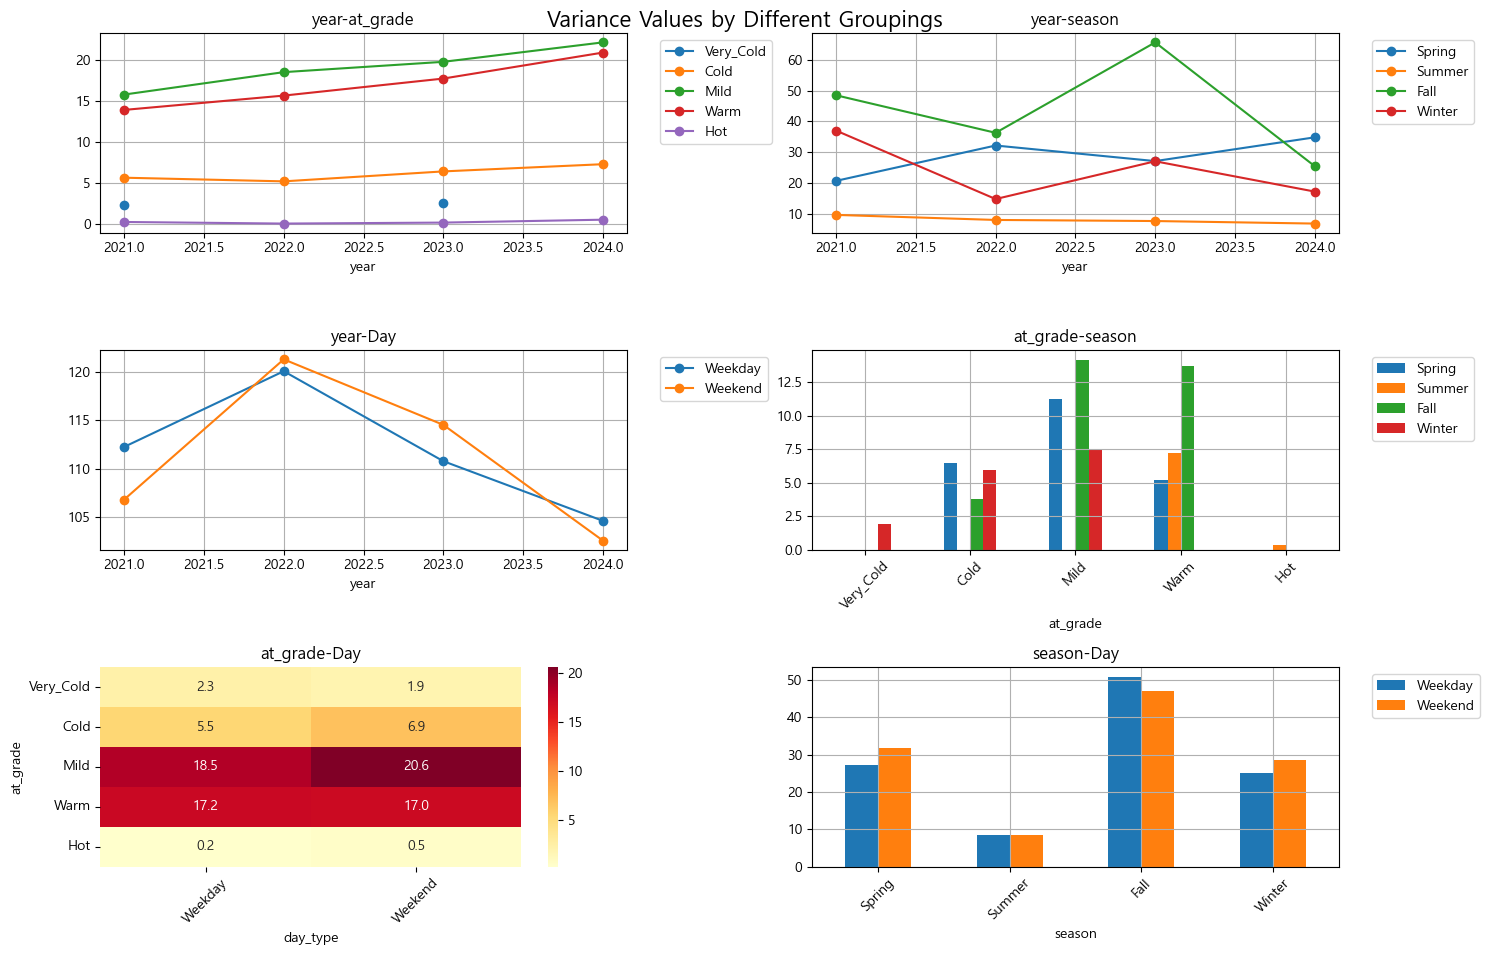

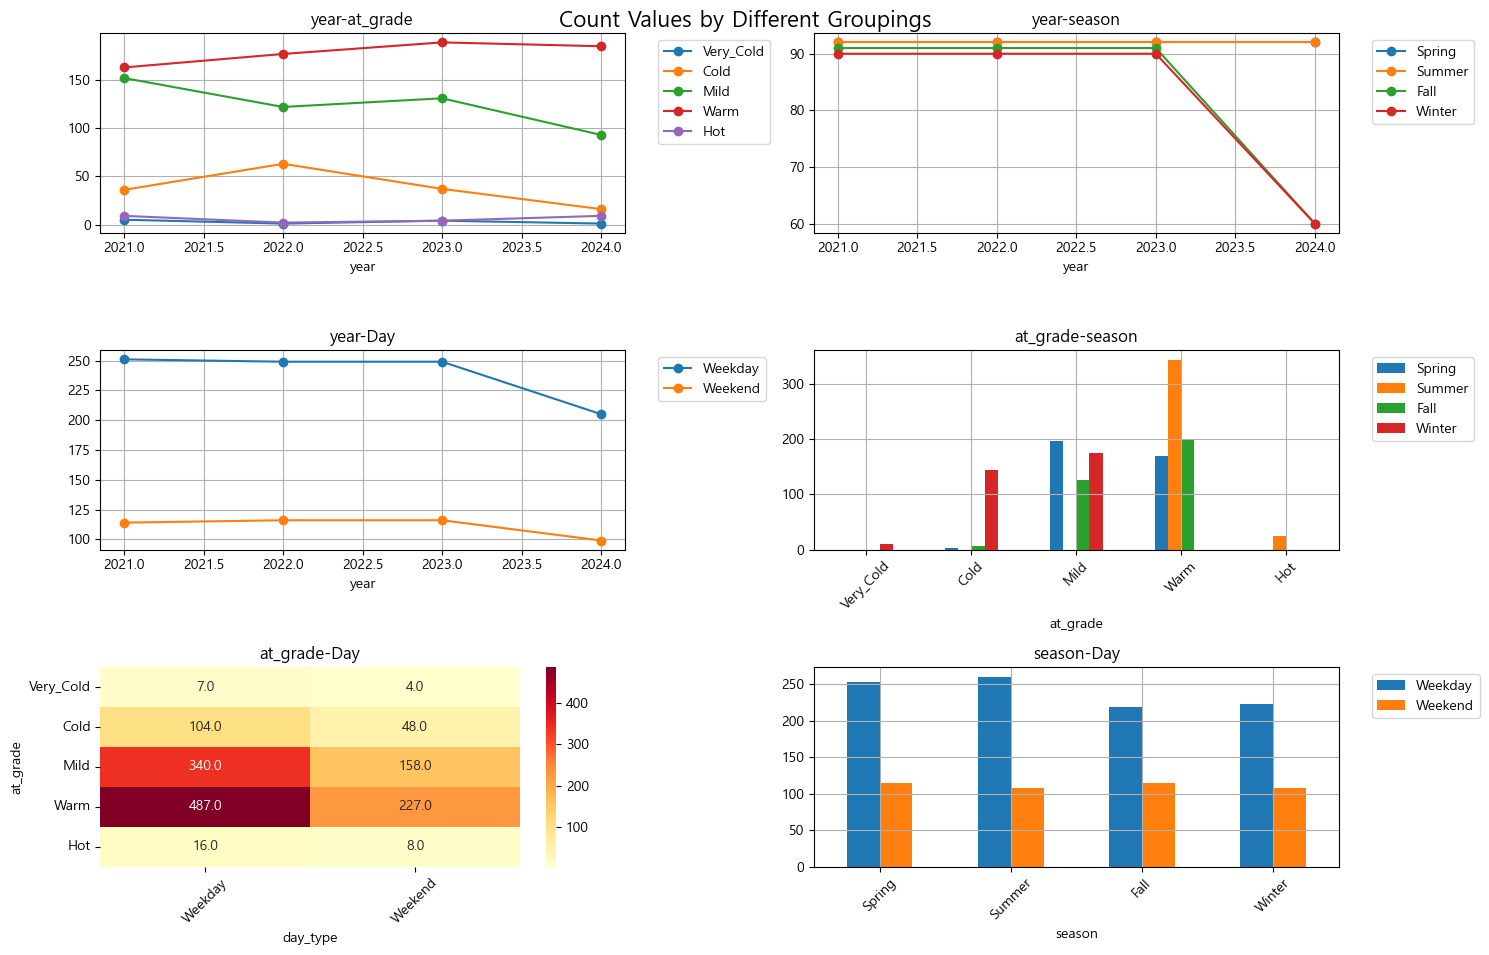

In [57]:
# 각 통계치별로 그래프 생성
metrics = ["Mean", "Max", "Min", "Variance", "Count"]
for metric in metrics:
    create_double_group_plots(double_group_stats_at2, metric=metric)

2-2-7. 강수량/적설량 분석을 위한 함수 정의

In [58]:
def group_analysis_by_two_columns(df, group_col1, group_col2, target_col):
    # 기본 통계치 계산
    stats = df.groupby([group_col1, group_col2], observed=True)[target_col].agg([
        ("tot_cnt", "count"),               # 전체 카운트
        ("cnt_nz", lambda x: (x != 0).sum()), # 0 제외 카운트
        ("zero_cnt", lambda x: (x == 0).sum()), # 0인 값의 카운트
        ("min", lambda x: x[x != 0].min()), # 0 제외 최소값
        ("max", "max"),
        ("mean", "mean"),
        ("med", "median"),
        ("var", "var"),
        ("q1", lambda x: x.quantile(0.25)),
        ("q3", lambda x: x.quantile(0.75)),
        ("iqr", lambda x: x.quantile(0.75) - x.quantile(0.25)),
        ("range", lambda x: x.max() - x.min())
    ])
    
    # 컬럼 순서 재정렬
    stats = stats[[
        # 카운트 관련 (0 포함/제외 구분)
        "tot_cnt", "cnt_nz", "zero_cnt",
        # 기본 통계치 (min은 0 제외)
        "min", "max", "mean", "med", "var",
        "q1", "q3", "iqr", "range"]]
    
    return stats

2-2-8. 강수량 - 분석

In [59]:
# 함수 실행 예시
df_year_p_grade_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "p_grade", 
    target_col = "precipitation(mm)")
df_year_season_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "precipitation(mm)")
df_year_day_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "precipitation(mm)")
df_p_grade_season_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "p_grade", 
    group_col2 = "season", 
    target_col = "precipitation(mm)")
df_p_grade_day_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "p_grade", 
    group_col2 = "day_type", 
    target_col = "precipitation(mm)")
df_season_day_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "precipitation(mm)")

# 결과를 딕셔너리로 정리
double_group_stats_p2 = {
    "year-p_grade": df_year_p_grade_stats,
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "p_grade-season": df_p_grade_season_stats,
    "p_grade-Day": df_p_grade_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 강수량")
for key, value in double_group_stats_p2.items():
    print(f"\n{key} Stats (강수량):\n", value)

2. 이중 그룹 분석 - 강수량

year-p_grade Stats (강수량):
                tot_cnt  cnt_nz  zero_cnt   min    max        mean     med  \
year p_grade                                                                
2021 Dry           248       0       248   NaN    0.0    0.000000    0.00   
     Light          88      88         0   0.1    9.3    2.860227    1.70   
     Moderate       21      21         0  10.5   38.2   19.452381   18.10   
     Heavy           8       8         0  56.2   77.4   65.787500   67.15   
2022 Dry           261       0       261   NaN    0.0    0.000000    0.00   
     Light          68      68         0   0.1    9.9    2.107353    1.25   
     Moderate       26      26         0  10.4   47.2   23.634615   19.30   
     Heavy          10      10         0  51.1  176.2  101.750000  108.75   
2023 Dry           256       0       256   NaN    0.0    0.000000    0.00   
     Light          70      70         0   0.1    9.7    2.467143    1.50   
     Moderate       31      31

2-2-9. 적설량 - 분석

In [60]:
# 함수 실행 예시
df_year_s_grade_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "s_grade", 
    target_col = "snow_depth(mm)")
df_year_season_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "snow_depth(mm)")
df_year_day_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "snow_depth(mm)")
df_s_grade_season_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "s_grade", 
    group_col2 = "season", 
    target_col = "snow_depth(mm)")
df_s_grade_day_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "s_grade", 
    group_col2 = "day_type", 
    target_col = "snow_depth(mm)")
df_season_day_stats = group_analysis_by_two_columns(
    df = all_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "snow_depth(mm)")

# 결과를 딕셔너리로 정리
double_group_stats_s2 = {
    "year-s_grade": df_year_s_grade_stats,
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "s_grade-season": df_s_grade_season_stats,
    "s_grade-Day": df_s_grade_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 적설량")
for key, value in double_group_stats_s2.items():
    print(f"\n{key} Stats (적설량):\n", value)

2. 이중 그룹 분석 - 적설량

year-s_grade Stats (적설량):
                     tot_cnt  cnt_nz  zero_cnt    min    max        mean  \
year s_grade                                                              
2021 No_Snow            340       0       340    NaN    0.0    0.000000   
     Light_Snow          14      14         0    1.0   18.0    8.214286   
     Moderate_Snow       11      11         0   23.0   51.0   39.000000   
2022 No_Snow            334       0       334    NaN    0.0    0.000000   
     Light_Snow          25      25         0    1.0   19.0    9.760000   
     Moderate_Snow        6       6         0   24.0   50.0   38.333333   
2023 No_Snow            349       0       349    NaN    0.0    0.000000   
     Light_Snow           9       9         0    2.0   17.0    7.888889   
     Moderate_Snow        6       6         0   21.0   88.0   42.666667   
     Heavy_Snow           1       1         0  122.0  122.0  122.000000   
2024 No_Snow            286       0       286    NaN  

2-2-10. 적설량과 강수량 날짜별 분포 시각화

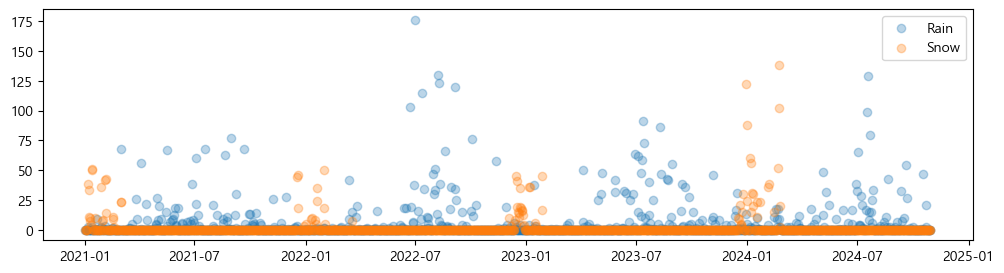

In [61]:
plt.figure(figsize=(12,3))
plt.scatter(all_df["date"], all_df["precipitation(mm)"], alpha=0.3, label = "Rain")
plt.scatter(all_df["date"], all_df["snow_depth(mm)"], alpha=0.3, label = "Snow")
plt.legend()
plt.show()

# 3. 데이터 분석 및 시각화(날씨와 날씨의 관계)

### 3-1. 두 날씨변수의 관계 - 상관계수/산점도

3-1-1. 미세먼지/평균기온

미세먼지와 평균기온 간의 상관계수: -0.23


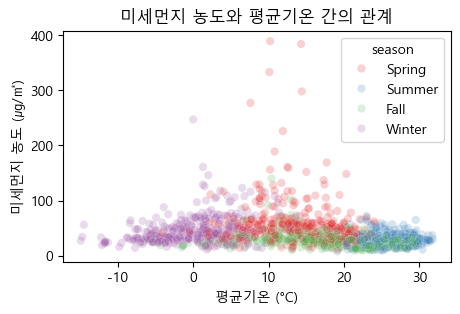

In [62]:
# 상관계수
correlation = all_df['fine_dust(㎍/㎥)'].corr(all_df['avg_temp'])
print(f"미세먼지와 평균기온 간의 상관계수: {correlation:.2f}")

# 산점도 그리기
plt.figure(figsize=(5, 3))
sns.scatterplot(data=all_df, x='avg_temp', y='fine_dust(㎍/㎥)', hue='season', palette='Set1', alpha = 0.2)
plt.title('미세먼지 농도와 평균기온 간의 관계')
plt.xlabel('평균기온 (°C)')
plt.ylabel('미세먼지 농도 (㎍/㎥)')
plt.show()


3-1-2. 미세먼지와 강수량

미세먼지와 평균기온 간의 상관계수: -0.12


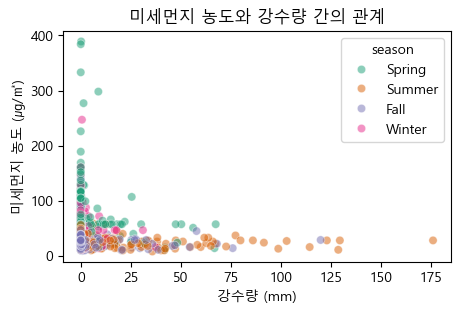

In [63]:
# 상관계수
correlation = all_df['fine_dust(㎍/㎥)'].corr(all_df['precipitation(mm)'])
print(f"미세먼지와 평균기온 간의 상관계수: {correlation:.2f}")

# 산점도 그리기
plt.figure(figsize=(5, 3))
sns.scatterplot(data=all_df, x='precipitation(mm)', y='fine_dust(㎍/㎥)', hue='season', palette='Dark2', alpha = 0.5)
plt.title('미세먼지 농도와 강수량 간의 관계')
plt.xlabel('강수량 (mm)')
plt.ylabel('미세먼지 농도 (㎍/㎥)')
plt.show()


3-1-3. 미세먼지와 적설량

미세먼지와 적설량 간의 상관계수: 0.01


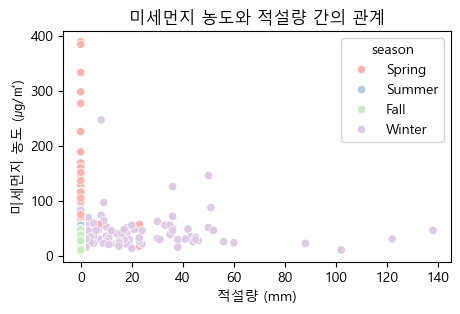

In [64]:
# 상관계수
correlation = all_df['fine_dust(㎍/㎥)'].corr(all_df['snow_depth(mm)'])
print(f"미세먼지와 적설량 간의 상관계수: {correlation:.2f}")

# 산점도 그리기
plt.figure(figsize=(5, 3))
sns.scatterplot(data=all_df, x='snow_depth(mm)', y='fine_dust(㎍/㎥)', hue='season', palette='Pastel1')
plt.title('미세먼지 농도와 적설량 간의 관계')
plt.xlabel('적설량 (mm)')
plt.ylabel('미세먼지 농도 (㎍/㎥)')
plt.show()


3-1-4. 강수량과 평균기온

강수량와 평균기온 간의 상관계수: 0.17


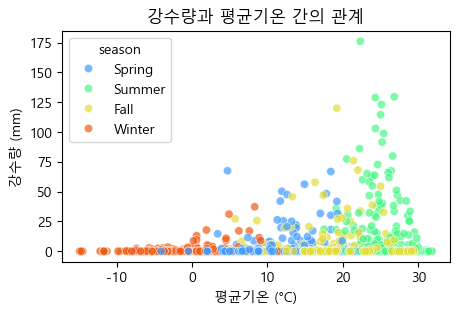

In [65]:
# 상관계수
correlation = all_df['precipitation(mm)'].corr(all_df['avg_temp'])
print(f"강수량와 평균기온 간의 상관계수: {correlation:.2f}")

# 산점도 그리기
plt.figure(figsize=(5, 3))
sns.scatterplot(data=all_df, x='avg_temp', y='precipitation(mm)', hue='season', palette='turbo', alpha = 0.7)
plt.title('강수량과 평균기온 간의 관계')
plt.xlabel('평균기온 (°C)')
plt.ylabel('강수량 (mm)')
plt.show()


3-1-5. 적설량과 평균기온

적설량와 평균기온 간의 상관계수: -0.28


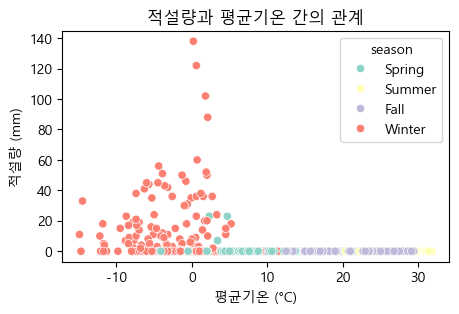

In [66]:
# 상관계수
correlation = all_df['snow_depth(mm)'].corr(all_df['avg_temp'])
print(f"적설량와 평균기온 간의 상관계수: {correlation:.2f}")

# 산점도 그리기
plt.figure(figsize=(5, 3))
sns.scatterplot(data=all_df, x='avg_temp', y='snow_depth(mm)', hue='season', palette='Set3')
plt.title('적설량과 평균기온 간의 관계')
plt.xlabel('평균기온 (°C)')
plt.ylabel('적설량 (mm)')
plt.show()


3-1-6. 강수량과 적설량

적설량와 강수량 간의 상관계수: -0.01


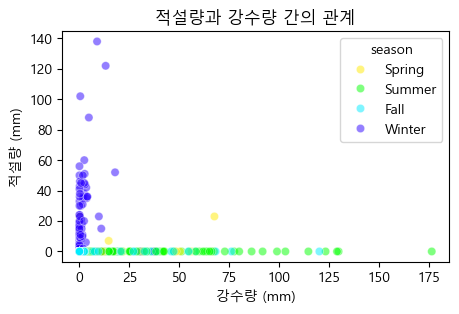

In [67]:
# 상관계수
correlation = all_df['snow_depth(mm)'].corr(all_df['precipitation(mm)'])
print(f"적설량와 강수량 간의 상관계수: {correlation:.2f}")

# 산점도 그리기
plt.figure(figsize=(5, 3))
sns.scatterplot(data=all_df, x='precipitation(mm)', y='snow_depth(mm)', hue='season', palette='gist_rainbow', alpha = 0.5)
plt.title('적설량과 강수량 간의 관계')
plt.xlabel('강수량 (mm)')
plt.ylabel('적설량 (mm)')
plt.show()


### 3-2. 세 날씨 변수의 관계

3-2-2. 미세먼지와 강수량과 평균기온

C:\Users\human\AppData\Local\Temp\ipykernel_5224\1125192291.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fd_p_avg = all_df.groupby(['fd_grade', 'p_grade'])['avg_temp'].mean().unstack()


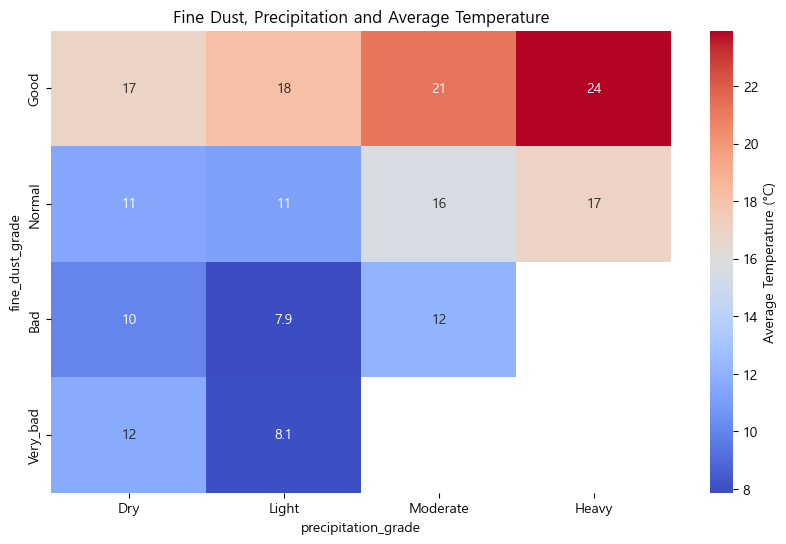

In [68]:
# 미세먼지등급, 강수량등급, 평균기온의 비교
fd_p_avg = all_df.groupby(['fd_grade', 'p_grade'])['avg_temp'].mean().unstack()

# 시각화 (히트맵)
plt.figure(figsize=(10, 6))
sns.heatmap(fd_p_avg, annot=True, cmap='coolwarm', cbar_kws={'label': 'Average Temperature (°C)'})
plt.title('Fine Dust, Precipitation and Average Temperature')
plt.xlabel('precipitation_grade')
plt.ylabel('fine_dust_grade')
plt.show()

3-2-2. 미세먼지와 적설량과 평균기온

C:\Users\human\AppData\Local\Temp\ipykernel_5224\3600865142.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fd_s_avg = all_df.groupby(['fd_grade', 's_grade'])['avg_temp'].mean().unstack()


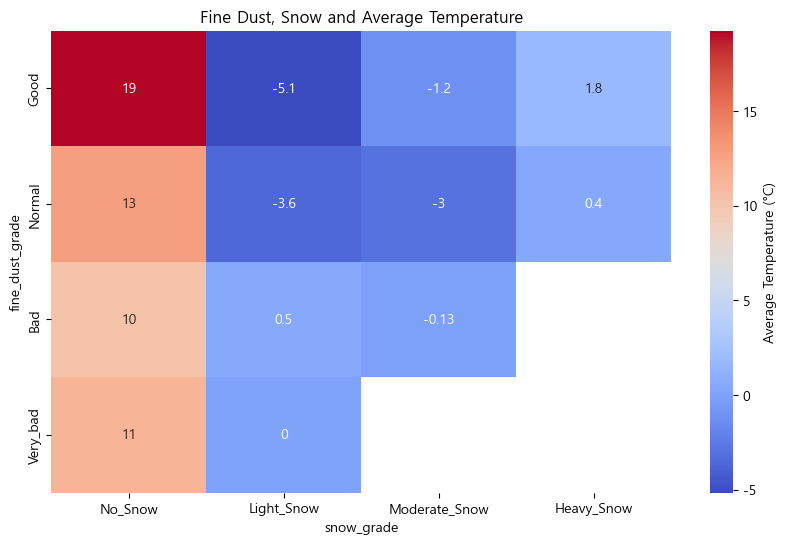

In [69]:
# 미세먼지등급, 적설량등급, 평균기온의 비교
fd_s_avg = all_df.groupby(['fd_grade', 's_grade'])['avg_temp'].mean().unstack()

# 시각화 (히트맵)
plt.figure(figsize=(10, 6))
sns.heatmap(fd_s_avg, annot=True, cmap='coolwarm', cbar_kws={'label': 'Average Temperature (°C)'})
plt.title('Fine Dust, Snow and Average Temperature')
plt.xlabel('snow_grade')
plt.ylabel('fine_dust_grade')
plt.show()

# 데이터프레임 저장

In [70]:
all_df.to_csv('data/all_weather.csv')

# 확인하기
df = pd.read_csv('data/all_weather.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1399 non-null   int64  
 1   date               1399 non-null   object 
 2   fine_dust(㎍/㎥)     1399 non-null   float64
 3   avg_temp           1399 non-null   float64
 4   min_temp           1399 non-null   float64
 5   max_temp           1399 non-null   float64
 6   precipitation(mm)  1399 non-null   float64
 7   snow_depth(mm)     1399 non-null   float64
 8   day_type           1399 non-null   object 
 9   season             1399 non-null   object 
 10  year               1399 non-null   int64  
 11  fd_grade           1399 non-null   object 
 12  p_grade            1399 non-null   object 
 13  s_grade            1399 non-null   object 
 14  at_grade           1399 non-null   object 
dtypes: float64(6), int64(2), object(7)
memory usage: 164.1+ KB
